<h1 style='text-align: center;'>BUDOWA MODELU XGBOOST NA DANYCH BANKOWYCH - CZĘŚĆ I</h1>

Celem owego raportu jest **zbudowanie modelu klasyfikacyjnego XGBoost** do przewidywania, czy klient zdecyduje się na lokatę terminową na podstawie cech demograficznych i informacji o kontakcie marketingowym.

## WCZYTANIE DANYCH I ZAPOZNANIE SIĘ Z ICH STRUKTURĄ


Na początku, wczytam potrzebne w dalszej części raportu bliblioteki oraz dane przeznaczone do analizy. Przedstawię ich pierwszych pięć wierszy, aby następnie zapoznać się z ich strukturą.

In [4]:
import pandas as pd
import openpyxl
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

dane=pd.read_csv("C:/Users/ASUS/Desktop/bankowość/lab 2/dane_list2.csv",sep=';')
dane.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Dane te dotyczą **kampanii marketingowych portugalskiej instytucji bankowej**. Kampanie te były prowadzone telefonicznie. Często konieczne było wykonanie więcej niż jednego kontaktu z tym samym klientem, aby ocenić, czy produkt (**lokata terminowa**) zostanie subskrybowany, czy nie. Owy zbiór danych zawiera wszystkie przykłady uporządkowane chronologicznie (od maja 2008 do listopada 2010). Celem tego raportu jest **przewidzenie, czy klient zdecyduje się na subskrypcję lokaty terminowej**. Liczba analizowanych rekordów to **45 211**, z kolei liczba atrybutów to **16 + zmienna wyjściowa**. 

#### OPIS ATRYBUTÓW


**Zmienne wejściowe**:

**Dane klienta banku:**


- **age** – wiek,
- **job** – rodzaj pracy ("admin.", "unknown", "unemployed", "management", "housemaid", "entrepreneur", "student", "blue-collar", "self-employed", "retired", "technician", "services"),
- **marital** – stan cywilny ("married" – zamężny/żonaty, "divorced" – rozwiedziony/wdowiec, "single" – singiel),
- **education** – poziom wykształcenia ("unknown", "secondary", "primary", "tertiary"),
- **default** – czy klient ma zaległości w spłacie kredytu?,
- **balance** – średnie roczne saldo na koncie klienta (w euro),
- **housing** – czy klient ma kredyt hipoteczny?,
- **loan** – czy klient ma kredyt gotówkowy?.


**Informacje o ostatnim kontakcie w bieżącej kampanii:**


- **contact** – typ komunikacji ("unknown", "telephone", "cellular"),
- **day** – dzień ostatniego kontaktu w miesiącu,
- **month** – miesiąc ostatniego kontaktu ("jan", "feb", "mar", ..., "nov", "dec"),
- **duration** – czas trwania ostatniego kontaktu (w sekundach).


**Inne zmienne:**


- **campaign** – liczba kontaktów wykonanych w tej kampanii dla danego klienta,
- **pdays** – liczba dni od ostatniego kontaktu klienta w poprzedniej kampanii (-1 oznacza, że klient nie był wcześniej kontaktowany),
- **previous** – liczba kontaktów wykonanych przed tą kampanią dla danego klienta,
- **poutcome** – wynik poprzedniej kampanii marketingowej ("unknown", "other", "failure", "success").



**Zmienna wyjściowa:**

**y** - czy klient zdecydował się na subskrypcję lokaty terminowej?.

## PRZYGOTOWANIE DANYCH DO MODELOWANIA

W celu przygotowania danych do modelowania, stworzę na początku **kolumnę jednoznacznie identyfikującą pojedynczą obserwację**. Zresetuję indeks danych i przeniosę go do nowej kolumny "index", której nazwę zmienię następnie na **"customer_id"**.

In [7]:
dane=dane.reset_index()
dane=dane.rename(columns={'index':'customer_id'})

Następnie, zamienię **kolumnę y na wartości binarne** (1 = *yes*, 0 = *no*).

In [9]:
pd.set_option('future.no_silent_downcasting', True)
dane["y"] = dane["y"].replace("yes", 1)
dane["y"] = dane["y"].replace("no", 0)

Zamienię teraz **zmienne kategoryczne na wartości numeryczne**. W przypadku rozważanych danych zmiennymi kategorycznymi są następujące zmienne: **job, marital, education, contact, month, poutcome** - zostaną one zmienione na wartości numeryczne. Utworzę na początku kopię omawianych danych, aby oryginalne dane pozostały niezmienione. Następnię, znajdę wszystkie kolumny, które mają typ "object" i zamienię wartości tekstowe na liczby. Zapiszę również to kodowanie w słowniku, aby w dalszej części raportu moć wykorzystać owe wartości.

In [11]:
encoder_dict = {}
dane2 = dane.copy()
encoder = LabelEncoder()
for col in dane2.select_dtypes(include='object').columns:
    dane2[col] = encoder.fit_transform(dane2[col])
    encoder_dict[col] = {i: label for i, label in enumerate(encoder.classes_)}

W ostatnim już punkcie tej części **podzielę dane na zbiór treningowy i testowy**. Celem jest nauczenie modelu na jednym zestawie danych (**zbiór treningowy**) i sprawdzenie, jak dobrze generalizuje na nowych, niewidzianych danych (**zbiór testowy**). Na początku utworzę listę kolumn oprócz "y" (zmienna docelowa) i "customer_id" (unikalne ID klienta, które nie jest cechą), a jako kolumnę docelową, czyli wartość, którą model ma przewidywać, ustawię kolumnę "y". Dalej, podzielę dane w taki sposób, że **20%** danych trafia do zbioru testowego, a **80%** do zbioru treningowego. Ustawię również **random_state**, co jest ważne w celu reprodukowalności wyników.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(dane2[[i for i in dane2.columns if i not in ['y','customer_id']]],
                                               dane2.y,
                                               test_size=0.2,
                                               random_state=20)

## EKSPLORACYJNA ANALIZA DANYCH

W tej części owego raportu zostanie przeprowadzona **eksploracyjna analiza danych**, która polega na badaniu, wizualizacji i interpretacji zbioru danych przed budową modelu predykcyjnego. Jej celem jest lepsze zrozumienie rozkładu i znaczenia zmiennych, zależności między nimi oraz potencjalnych problemów występujących w danych.

#### ZNACZENIE DANYCH

Zbiór rozważanych danych pochodzi z kampanii marketingowych portugalskiej instytucji bankowej, a jego celem jest przewidzenie, czy klient zdecyduje się na subskrypcję lokaty terminowej. Dane te obejmują informacje o klientach, ich historii kontaktów z bankiem oraz wyniki wcześniejszych kampanii marketingowych. Opis atrybutów został przedstawiony w poprzedniej części raportu.


Zmienna **y** to zmienna docelowa, którą chcemy przewidzieć na podstawie pozostałych zmiennych. **Dane klienta banku** pomagają określić, kto statystycznie częściej decyduje się na lokatę. **Informacje o ostatnim kontakcie w bieżącej kampanii** pozwalają przypuszczać, czy na przykład czas rozmowy wpływa na decyzję klienta. Z kolei **historia kontaktów** daje między innymi informacje o skuteczności wcześniejszych kampanii, które również są istotne w procesie przewidywania zmiennej docelowej.

#### SPRAWDZENIE ROZKŁADÓW

W tej części zostanie przeprowadzona ocena rozkładów dla zmiennych w zbiorach treningowym i testowym, aby sprawdzić, jak rozkładają się dane w obu zbiorach oraz aby zwrócić uwagę na potencjalne różnice, które mogą mieć wpływ na późniejsze modelowanie. W przypadku zmiennych ciągłych zostaną przedstawione histogramy oraz boxploty. Z kolei dla zmiennych dyskretnych zostaną ukazane wykresy słupkowe, które obrazują liczbę wystąpień poszczególnych kategorii w zbiorze danych. Utworzę zatem dwie funkcje, które będą realizować tę koncepcję.

In [22]:
def plot_continuous_variable(df_train, df_test, col):

    plt.style.use('ggplot')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.hist(df_train[col], edgecolor = 'black', color = 'purple', bins = 30, label = "zbiór treningowy")
    ax1.hist(df_test[col], edgecolor = 'black', color = "pink", bins = 30, label = "zbiór testowy")
    ax1.set_title(f'Porównanie histogramów - {col}')
    ax1.set_xlabel(col)
    ax1.legend()
    

    ax2.boxplot([df_train[col], df_test[col]], patch_artist=True, 
                boxprops=dict(facecolor='purple', color='black'),
                flierprops=dict(markerfacecolor='black', marker='o', markersize=5),
                medianprops=dict(color='black'))
    ax2.set_title(f'Porównanie boxplotów - {col}')
    ax2.set_xticklabels(['zbiór treningowy', 'zbiór testowy'])
    ax2.set_ylabel(col)
    
    plt.tight_layout()
    plt.show()


def plot_discrete_variable(df_train, df_test, col):

    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(10, 6))

    sns.countplot(x=df_train[col], color='purple', label='zbiór treningowy', ax=ax)
    sns.countplot(x=df_test[col], color='pink', label='zbiór testowy', ax=ax)

    ax.set_title(f'Porównanie barplotów - {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('liczba wystąpień')

    unique_labels_train = sorted(df_train[col].unique())
    unique_labels_test = sorted(df_test[col].unique())

    unique_labels = sorted(set(unique_labels_train).union(set(unique_labels_test)))

    ax.set_xticks(range(len(unique_labels)))
    ax.set_xticklabels([encoder_dict[col][label] for label in unique_labels], rotation=90)
    ax.legend()

    plt.tight_layout()
    plt.show()

##### AGE - WIEK KLIENTA BANKU

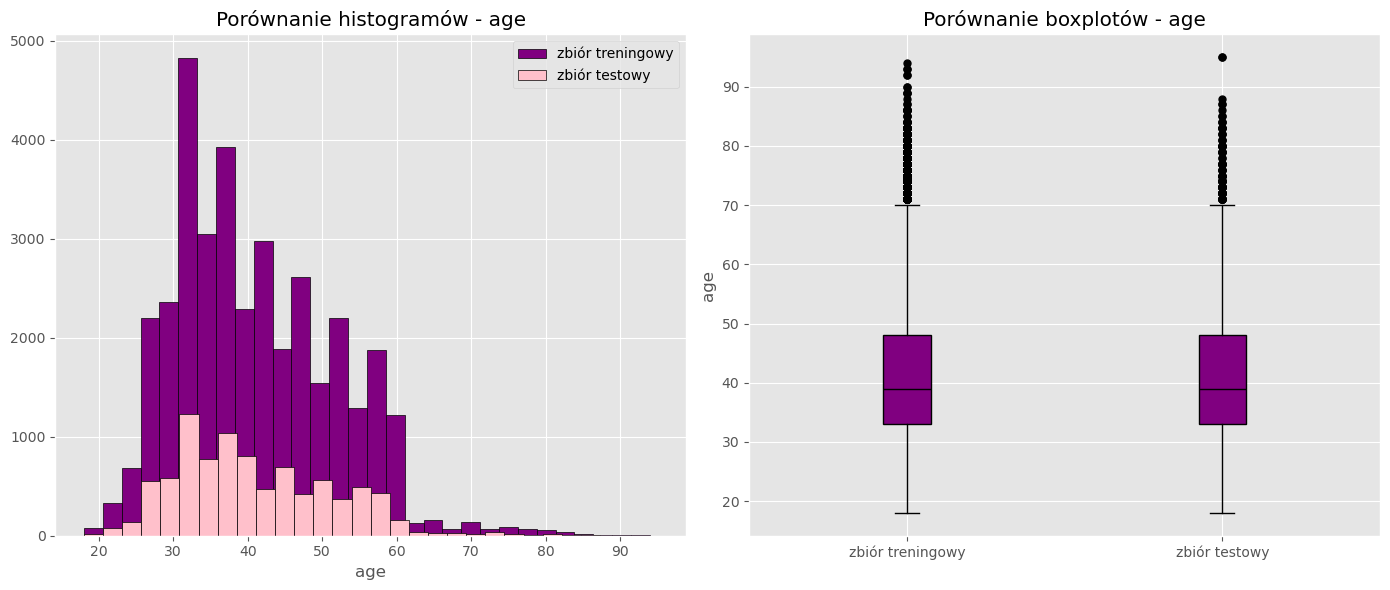

In [25]:
plot_continuous_variable(X_train, X_test, "age")

Na przedstawionych histogramach widzimy, iż rozkłady w zbiorach treningowym i testowym są do siebie zbliżone, co oznacza, że podział danych został dokonany poprawnie i nie powinien prowadzić do niewłaściwych wyników. Ponadto, możemy zauważyć, iż rozkład wieku jest prawoskośny, co oznacza, że większość klientów znajduje się w młodszych i średnich przedziałach wiekowych, natomiast liczba starszych klientów znacząco maleje. Z kolei analizując wykresy pudełkowe, widzimy, że mają one podobne kształty, co potwierdza równomierny podział danych. Ponadto, większość klientów mieści się w przedziale 30-50 lat, a mediana znajduje się w okolicach 38 lat. Widoczne są również liczne wartości odstające dla wieku powyżej 70 lat.

##### JOB - RODZAJ PRACY KLIENTA BANKU

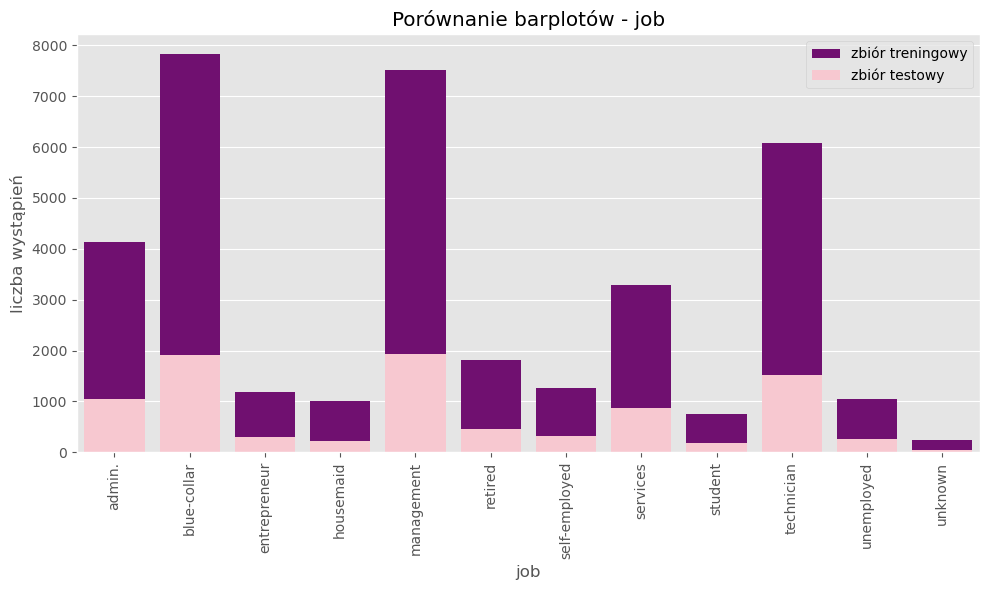

In [28]:
plot_discrete_variable(X_train, X_test, "job")

Widzimy, iż podział klientów pomiędzy zbiory treningowe i testowe jest równomierny dla każdej kategorii zawodowej, co wskazuje na prawidłowy podział danych. Proporcje między liczbą klientów w zbiorze treningowym i testowym w każdej grupie są podobne. Ponadto, możemy zauważyć, że najliczniejsze grupy zawodowe wśród klientów banku to: blue-collar (robotnicy fizyczni), management (kadra zarządzająca) oraz technician (technicy). Z kolei najmniej liczne grupy to: unknown (klienci bez określonego zawodu), student (studenci) i housemaid (pomoc domowa).

##### MARITAL - STAN CYWILNY KLIENTA BANKU

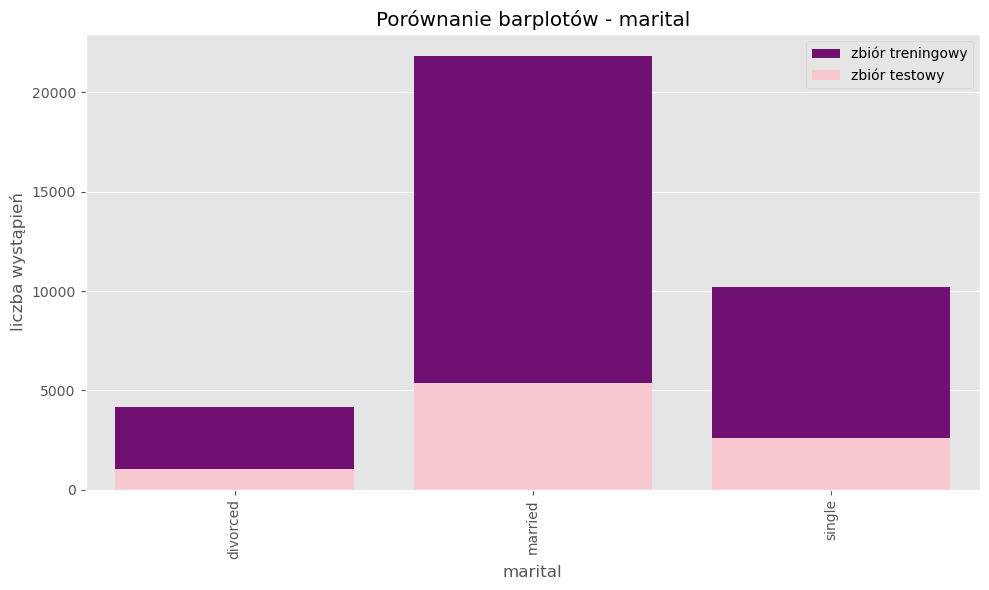

In [33]:
plot_discrete_variable(X_train, X_test, "marital")

Na przedstawionym wykresie słupkowym widzimy, iż podział klientów między zbiór treningowy i testowy wygląda proporcjonalnie dla każdej kategorii stanu cywilnego, co jest zgodne z założeniami podziału danych. Ponadto, możemy zauważyć, że największa grupa to osoby zamężne/żonate (married) - stanowią one zdecydowaną większość klientów. Druga pod względem wielkości grupa to osoby samotne (single). Z kolei najmniejszą grupę stanowią osoby rozwiedzione (divorced) - ich liczba jest zdecydowanie najmniejsza w całym zbiorze.

##### EDUCATION - POZIOM WYKSZTAŁCENIA KLIENTA BANKU

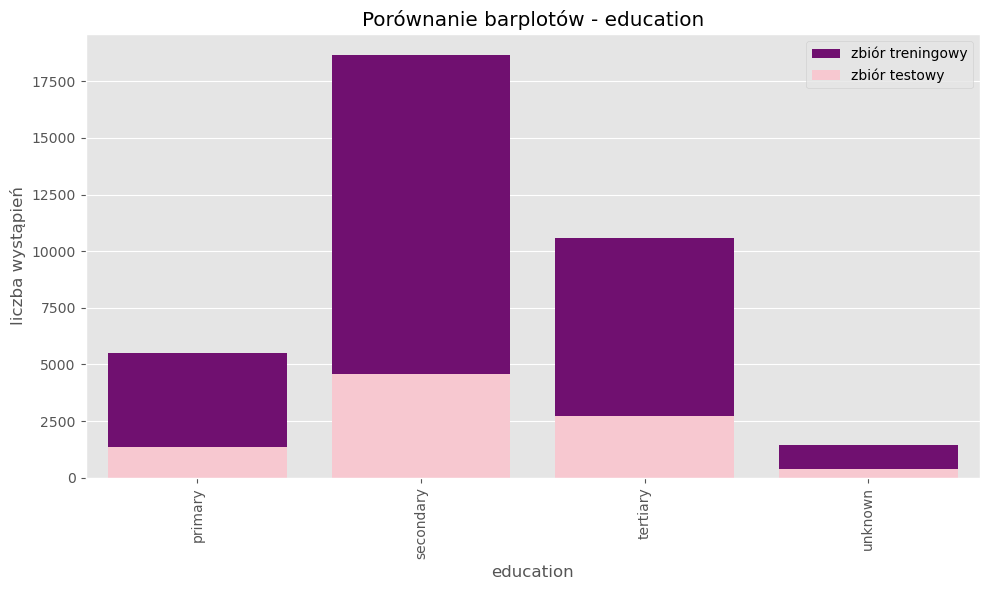

In [37]:
plot_discrete_variable(X_train, X_test, "education")

Ponownie widzimy, iż każda kategoria reprezentowana jest w zbiorach treningowym i testowym w podobnych proporcjach. Zbiór testowy stanowi mniejszą część każdej grupy, co jest zgodne z oczekiwaniami dotyczącymi podziału danych. Możemy również zauważyć, iż największa grupa klientów ma wykształcenie średnie (secondary) - liczba ta znacznie przewyższa inne kategorie. Drugą największą grupę stanowią osoby z wykształceniem wyższym (tertiary), choć ich liczba jest wyraźnie mniejsza niż w przypadku osób z poprzedniej omawianej kategorii. Następnie, osoby z wykształceniem podstawowym (primary) stanowią mniejszą grupę, a najmniej klientów ma nieznany poziom wykształcenia (unknown) - grupa ta jest marginalna.

##### DEFAULT - CZY KLIENT BANKU MA ZALEGŁOŚCI W SPŁACIE KREDYTU?

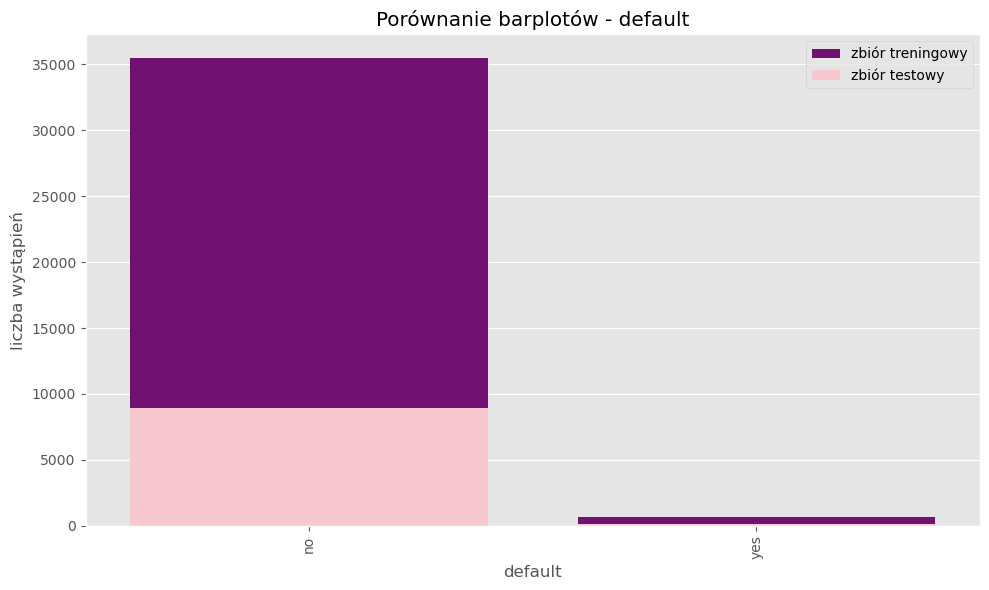

In [41]:
plot_discrete_variable(X_train, X_test, "default")

Ponownie możemy wyciągnąć wniosek, że podział danych na zbiór treningowy i testowy jest zgodny z oczekiwaniami - obie grupy są reprezentowane proporcjonalnie. Obserwujemy także fakt, iż rozważana zmienna jest wyraźnie niezrównoważona - bardzo mało klientów ma zaległości w spłacie kredytu, co może stanowić wyzwanie dla modeli predykcyjnych. Zdecydowana większość klientów nie ma zaległości w spłacie kredytu - ta kategoria znacząco dominuje w danych.

##### BALANCE - ŚREDNIE ROCZNE SALDO NA KONCIE KLIENTA BANKU (W EURO)

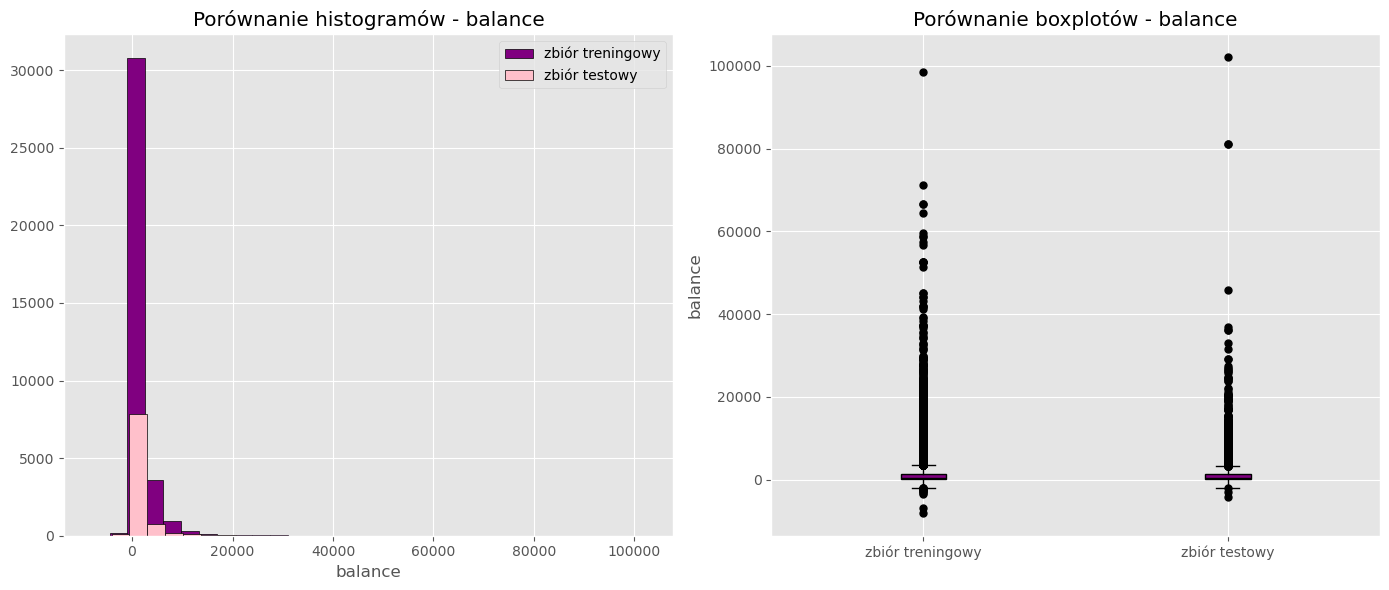

In [45]:
plot_continuous_variable(X_train, X_test, "balance")

Możemy zauważyć, iż występuje podobna struktura danych w zbiorach treningowym i testowym, co sugeruje, że dokonany podział na te dwa zestawy został wykonany poprawnie. Analizując histogramy, widzimy, że rozważana zmienna jest silnie skośna. Wykres ten pokazuje wyraźne skupienie danych w pobliżu zera - większość klientów ma niewielkie dodatnie saldo. Widzimy również długi prawy ogon rozkładu, co pokazuje, że w danych występują osoby z bardzo wysokim saldem. Warto również zwrócić uwagę, że występują także przypadki z ujemnymi wartościami. Z kolei analizując wykresy pudełkowe, możemy zauważyć, że występuje bardzo dużo wartości odstających - wyniki powyżej około 5000 euro oraz poniżej 0 są traktowane jako odstające.

##### HOUSING - CZY KLIENT BANKU MA KREDYT HIPOTECZNY?

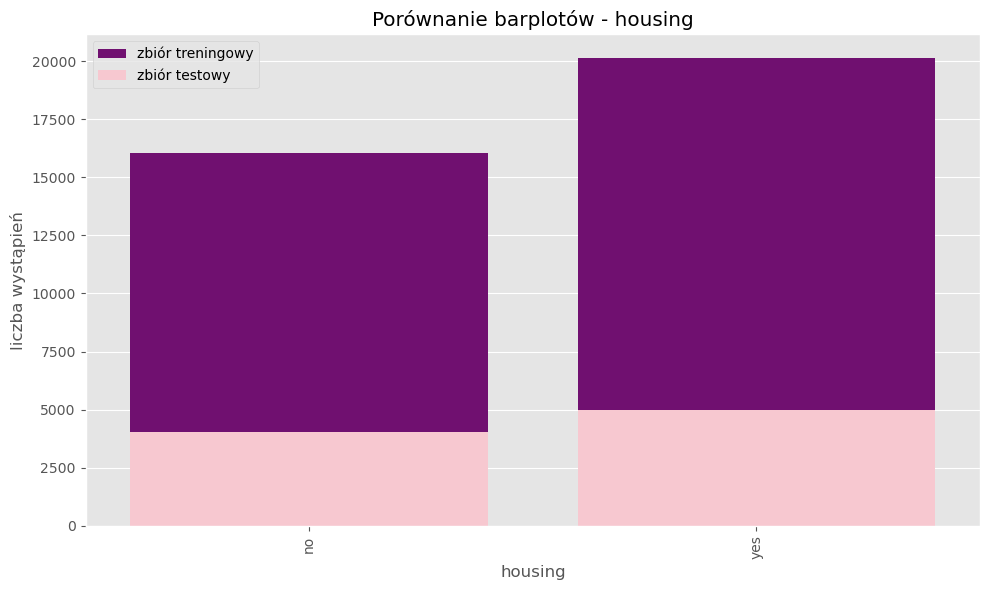

In [49]:
plot_discrete_variable(X_train, X_test, "housing")

Ponownie widzimy, że struktura danych jest podobna w zbiorach treningowym i testowym. Możemy zauważyć, że większość klientów banku posiada kredyt hipoteczny, choć nie jest to bardzo duża różnica. 

##### LOAN - CZY KLIENT MA KREDYT GOTÓWKOWY?

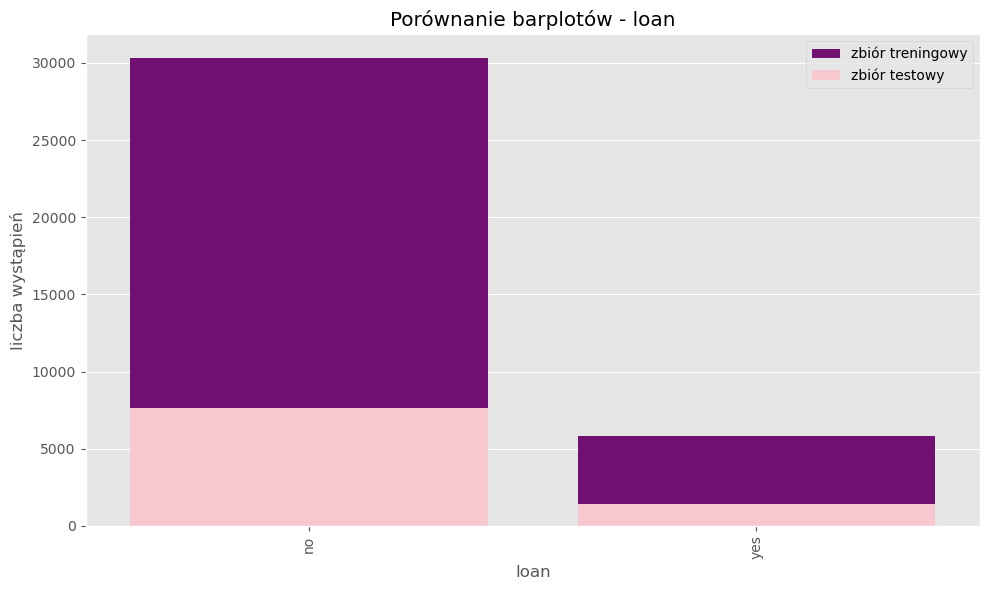

In [53]:
plot_discrete_variable(X_train, X_test, "loan")

Na podstawie przedstawionego wykresu ponownie możemy wyciągnąć wniosek, że struktura danych w zbiorach treningowym i testowym jest zbliżona, co wskazuje na dobrze przeprowadzony podział danych. Widzimy również, że zdecydowana większość klientów nie posiada kredytu gotówkowego - kategoria ta ma znacznie więcej przypadków. 

##### CONTACT - TYP KOMUNIKACJI

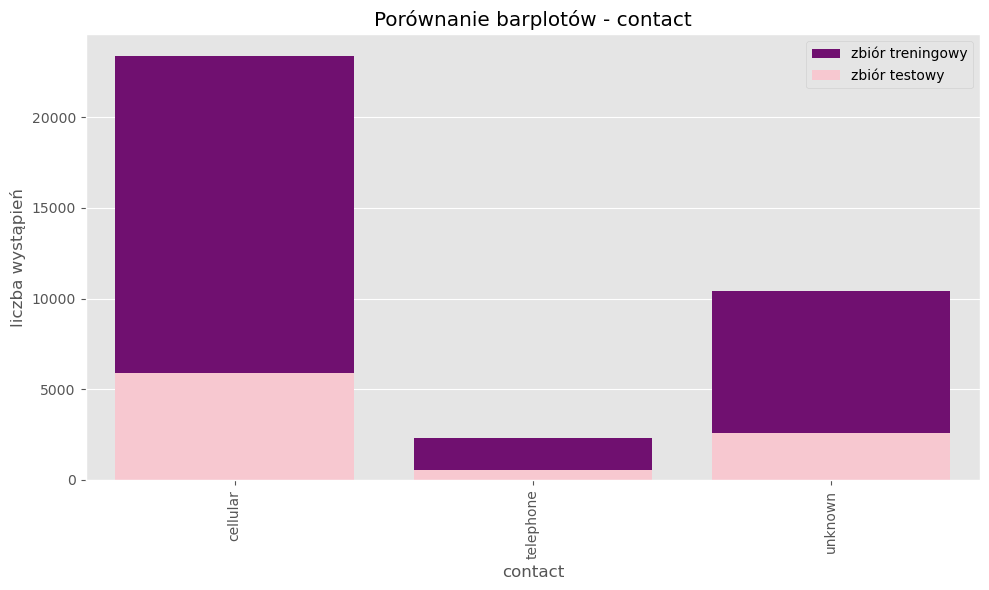

In [57]:
plot_discrete_variable(X_train, X_test, "contact")

Widzimy ponownie, iż dane na zbiory treningowy i testowy są dobrze podzielone. Możemy zauważyć, iż ostatni kontakt w bieżącej kampanii z większością klientów był przeprowadzony przez telefon komórkowy (celluar). Grupa unknown (brak informacji o metodzie kontaktu) jest mniej liczna, ale nadal zawiera sporą część klientów. Z kolei najmniejsza liczba kontaktów miała miejsce z wykorzystaniem telefonu stacjonarnego. Widzimy zatem, że telefon komórkowy zdecydowanie jest dominującym sposobem kontaktu.

##### DAY - DZIEŃ OSTATNIEGO KONTAKTU W MIESIĄCU

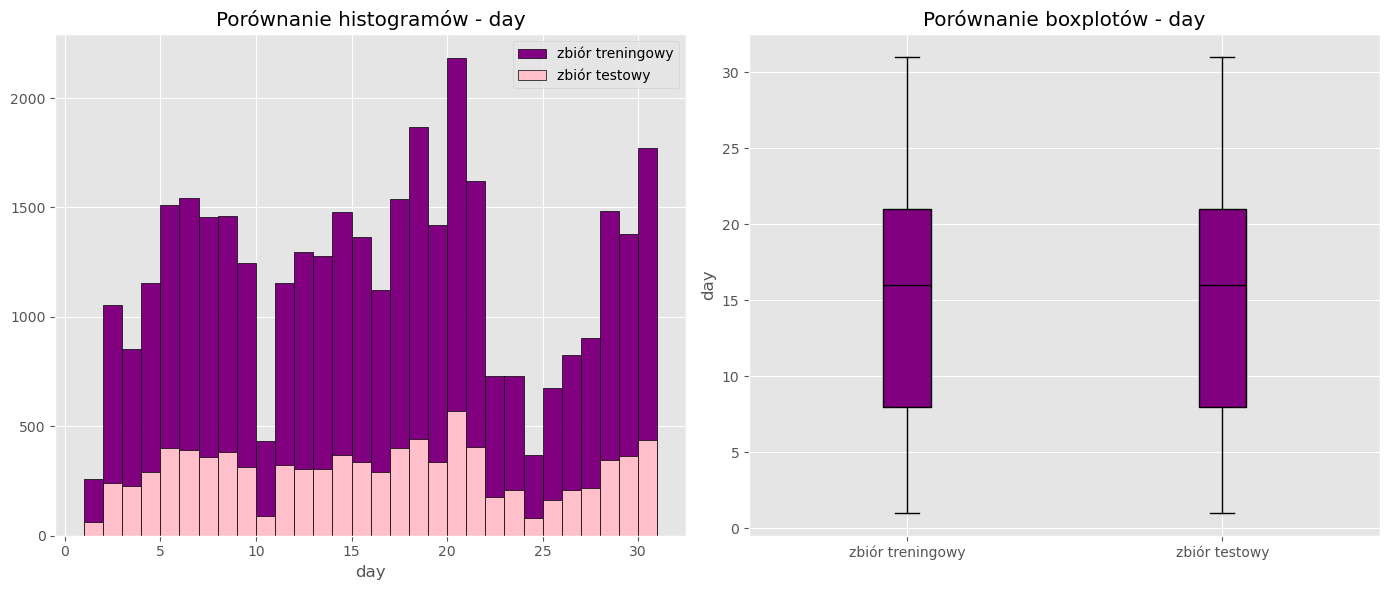

In [61]:
plot_continuous_variable(X_train, X_test, "day")

Widzimy ponownie, że struktura danych w zbiorach testowym i treningowym jest bardzo podobna, co oznacza dobrze podzielone dane. Analizując histogramy, możemy zauważyć, iż rozkład jest różnorodny, ale widać pewne skoki częstotliwości kontaktu w konkretne dni - najwięcej kontaktów miało miejsce w okolicach 20. dnia miesiąca. Z kolei rozważając wykresy pudełkowe, widzimy, że rozkład jest równomierny - nie ma zauważalnych wartości odstających, a jego mediana przypada na okolice 16. dnia miesiąca.

##### MONTH - MIESIĄC OSTATNIEGO KONTAKTU

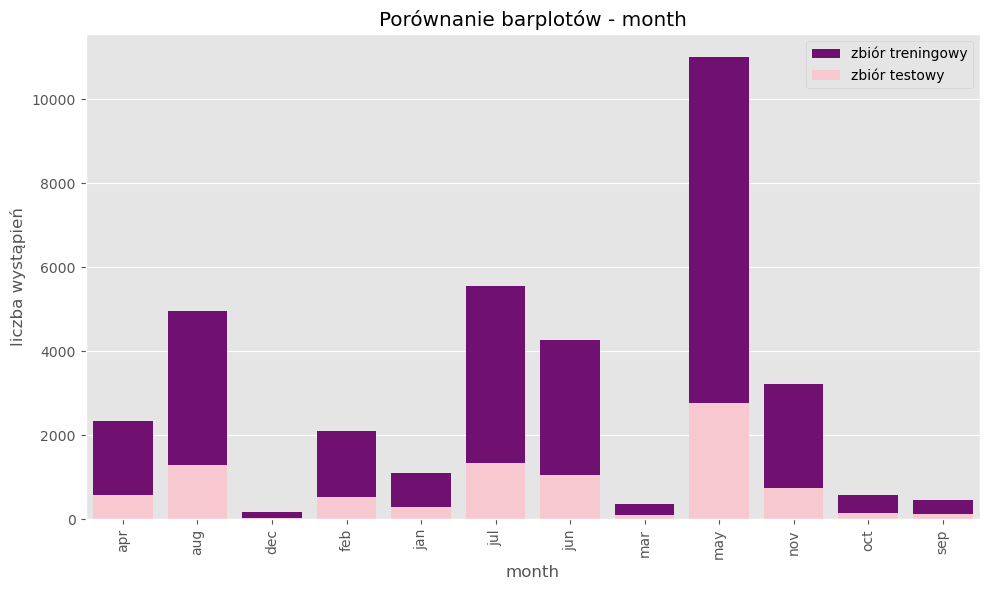

In [65]:
plot_discrete_variable(X_train, X_test, "month")

Ponownie możemy wyciągnąć wniosek, że podział na zbiór testowy i treningowy jest dobrze zrównoważony. Widzimy również, że najwięcej kontaktów miało miejsce w maju. Może to oznaczać, że w tym miesiącu kampania była prowadzona ze zwiększoną intensywnością. Z kolei pozostałe miesiące są mniej intensywne, ale widać też większą liczbę kontaktów w czerwcu, lipcu i sierpniu (okres letni). Natomiast marzec, wrzesień, październik i grudzień mają bardzo małą liczbę kontaktów, co może oznaczać, że w tych okresach kampania była ograniczona.

##### DURATION - CZAS TRWANIA OSTATNIEGO KONTAKTU (W SEKUNDACH)

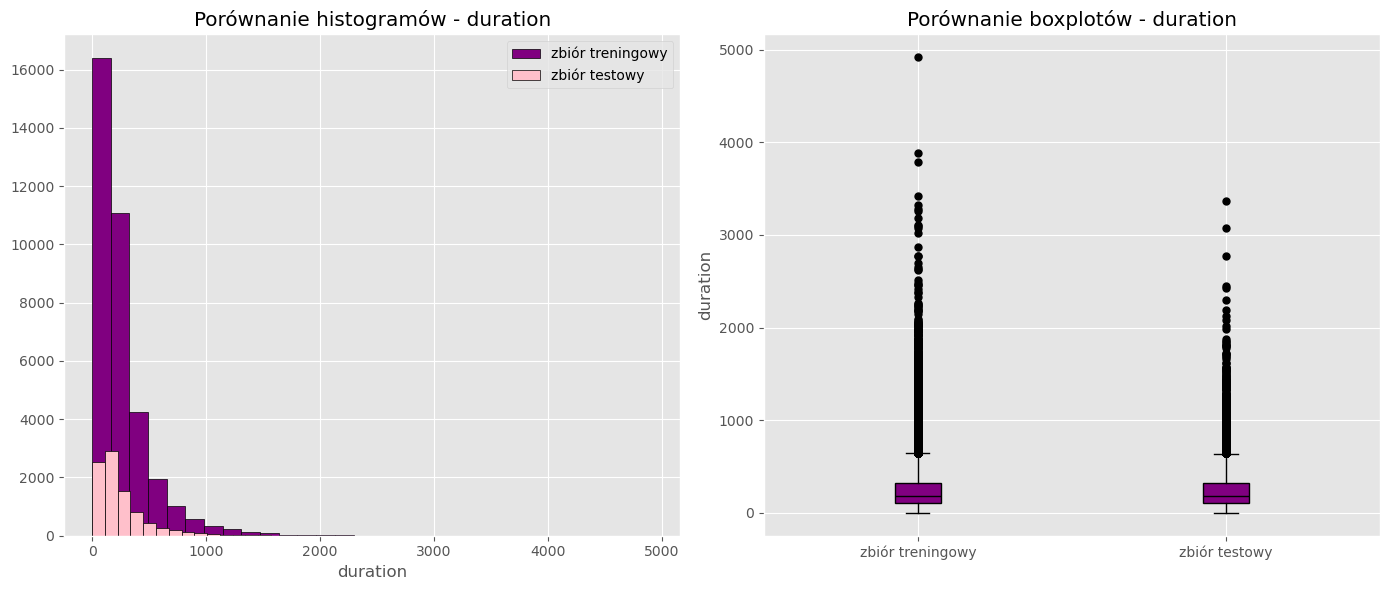

In [69]:
plot_continuous_variable(X_train, X_test, "duration")

Pierwszym wsnioskiem jest fakt, iż rozkład danych w zbiorze treningowym i testowym jest podobny. Analizując histogramy, możemy zauważyć, że pokazują one silną asymetrię prawostronną - większość rozmów trwa bardzo krótko, z dużą liczbą kontaktów poniżej 200 sekund. Z kolei patrząc na wykresy pudełkowe, widzimy, iż występuje bardzo dużo obserwacji odstających. Niektóre rozmowy trwały nawet ponad 4000 sekund, czyli ponad godzinę. Jednak większość rozmów była bardzo krótka, co może sugerować szybkie odrzucanie oferty przez klientów.

##### CAMPAIGN - LICZBA KONTAKTÓW WYKONANYCH W TEJ KAMPANII DLA DANEGO KLIENTA

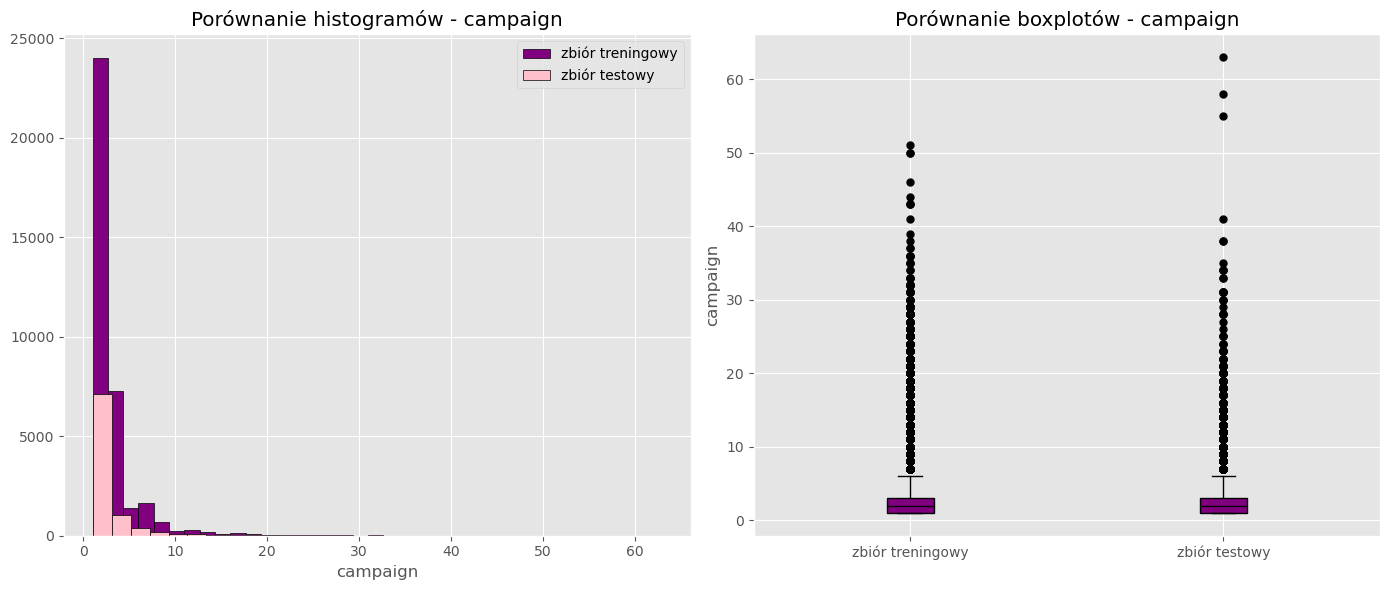

In [73]:
plot_continuous_variable(X_train, X_test, "campaign")

Widzimy, że rozkład w zbiorze treningowym i testowym jest bardzo podobny, co sugeruje, że podział danych został przeprowadzony poprawnie. Analizując histogramy, widzimy silną asymetrię prawostronną - większość klientów była kontaktowana tylko raz lub kilka razy, ale są też przypadki, gdzie liczba kontaktów przekracza 50. Z kolei patrząc na wykresy pudełkowe, możemy zauważyć, że występuje bardzo dużo wartości odstających - niektórzy klienci byli kontaktowani nawet ponad 60 razy. Z kolei mediana oscyluje w okolicach 2-3 kontaktów.

##### PDAYS - LICZBA DNI OD OSTATNIEGO KONTAKTU KLIENTA W POPRZEDNIEJ KAMPANII

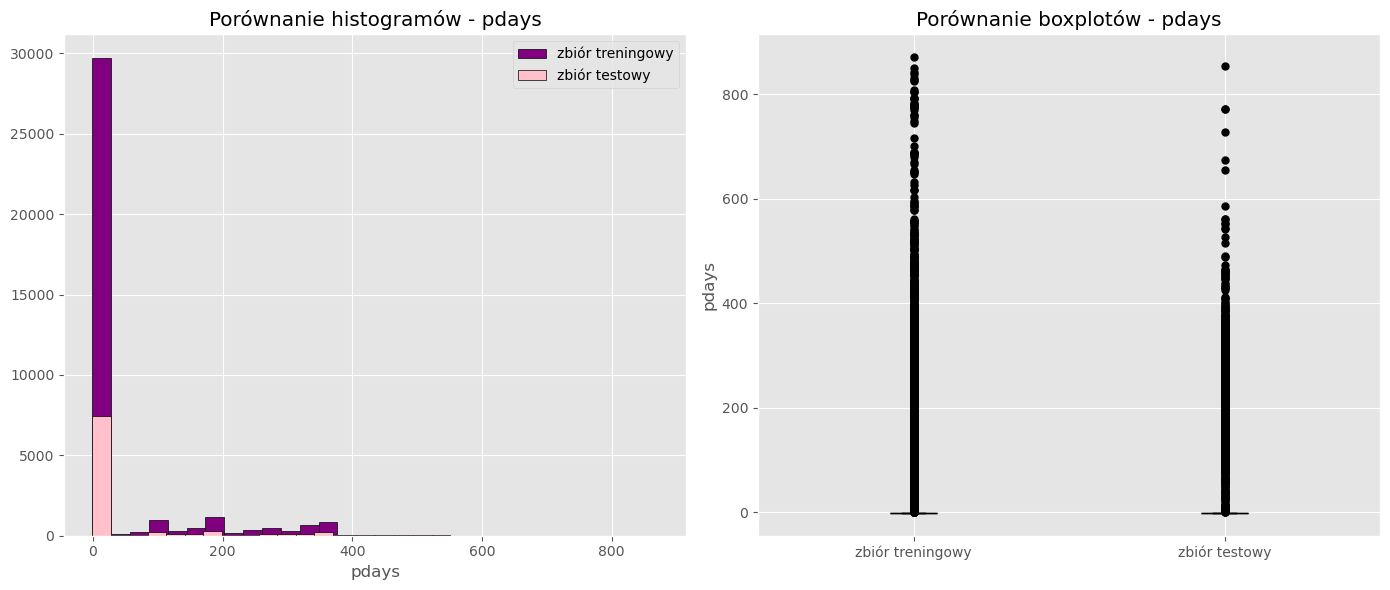

In [77]:
plot_continuous_variable(X_train, X_test, "pdays")

Widzimy znów, iż rozkład dla zbiorów treningowego i testowego wygląda bardzo podobnie, co sugeruje, że podział danych jest prawidłowy. Analizując histogramy, widzimy, że najczęściej pojawia się wartość bliska zera, co oznacza, że wielu klientów było kontaktowanych w bieżącej kampanii po raz pierwszy. Poza tymi wielkościami wartości rozkładają się w zakresie od kilku do ponad 800 dni. Z kolei patrząc na wykresy pudełkowe, możemy zauważyć, iż występuje bardzo wiele obserwacji odstających, szczególnie dla klientów, którzy byli kontaktowani setki dni temu.

##### PREVIOUS - LICZBA KONTAKTÓW WYKONANYCH PRZED TĄ KAMPANIĄ DLA DANEGO KLIENTA

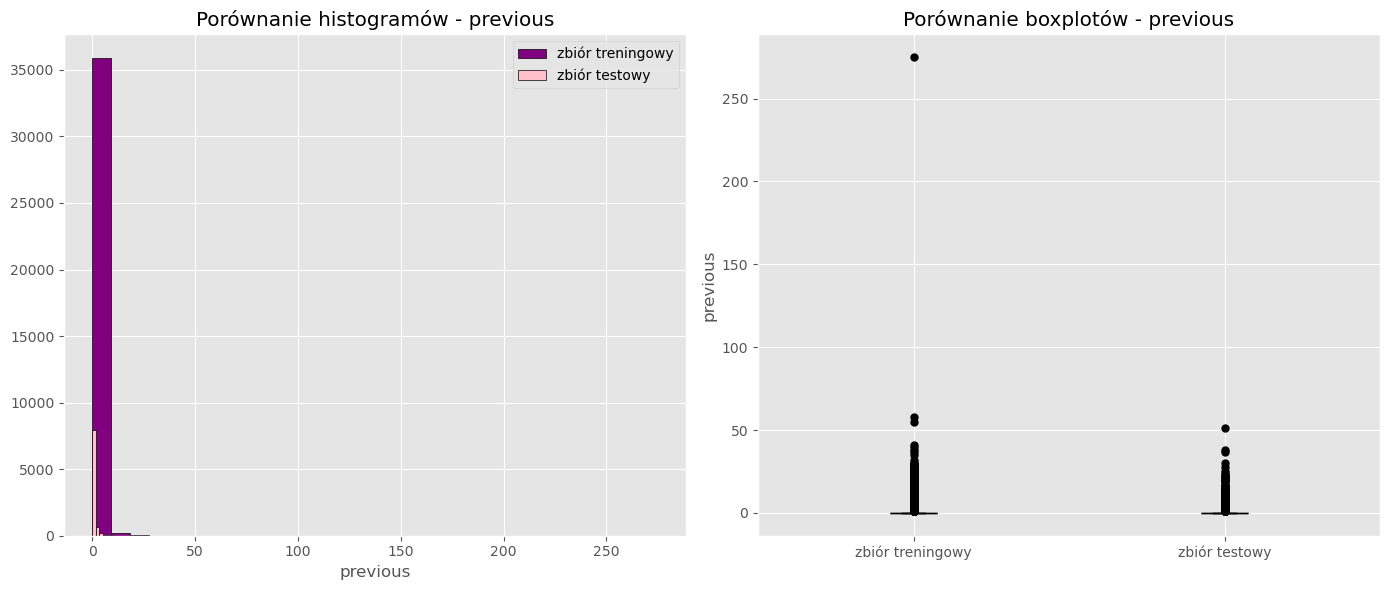

In [81]:
plot_continuous_variable(X_train, X_test, "previous")

Widzimy, iż dane są poprawnie podzielone pomiędzy zbiory treningowy i testowy. Analizując histogramy, widzimy, że najczęściej występują wartości bliskie 0, co oznacza, że wielu klientów banku nie było kontaktowanych w poprzednich kampaniach. Poza zerem wartości są bardzo niskie - większość klientów miała maksymalnie kilka kontaktów przed obecną kampanią. Z kolei patrząc na wykresy pudełkowe, możemy zauważyć, iż występuje bardzo dużo wartości odstających - niektórzy klienci byli kontaktowani nawet ponad 250 razy, co jest skrajnym przypadkiem.

##### POUTCOME - WYNIK POPRZEDNIEJ KAMPANII MARKETINGOWEJ

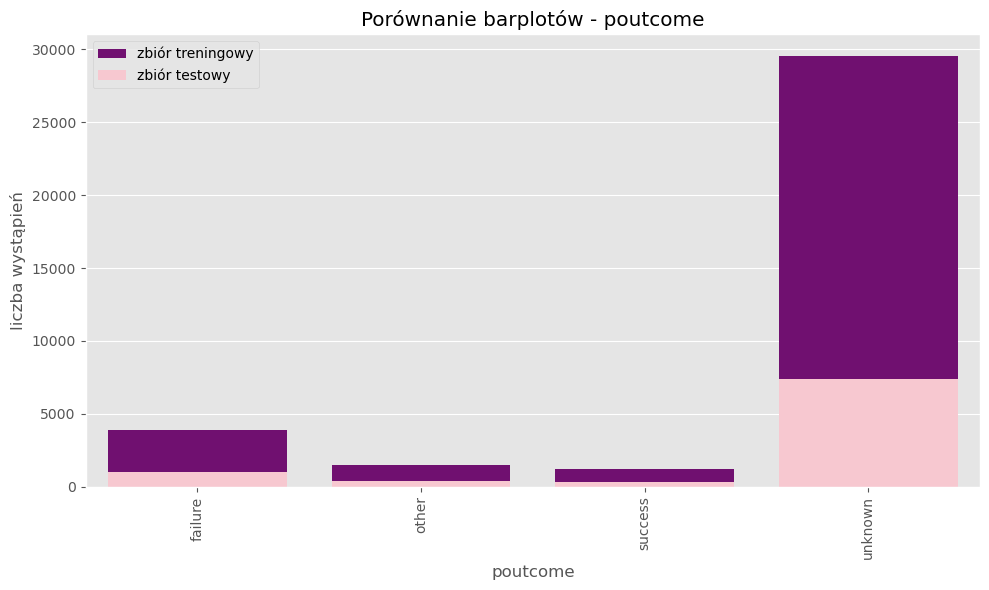

In [85]:
plot_discrete_variable(X_train, X_test, "poutcome")

Widzimy ponownie, że rozkład między zbiorami treningowym i testowym wygląda podobnie, co jest pozytywne dla modelowania. Możemy także zauważyć, iż najwięcej klientów banku ma wartość unknown, co oznacza, że dla większości osób nie mamy informacji o wyniku poprzedniej kampanii. Może to sugerować, że wielu klientów jest nowymi osobami, które nie brały udziału w poprzednich kampaniach. Widzimy również, iż niepowodzenie (failure) występuje znacznie częściej niż sukces (success). Kategorie other i success mają najmniejszą liczbę wystąpień.

#### SPRAWDZENIE STATYSTYK OPISOWYCH


W tej części raportu zostaną omówione statystyki opisowe dla poszczególnych zmiennych, aby jeszcze dokładniej poznać ich strukturę. Przedstawię zatem tabelę owych statystyk, by móc je przeanalizować. Zrobię to na początku dla zbioru treningowego, a następnie porównam te wyniki ze zbiorem testowym.

In [89]:
display(X_train.describe().style.format("{:.2f}"))

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
count,36168.00,36168.00,36168.00,36168.00,36168.00,36168.00,36168.00,36168.00,36168.00,36168.00,36168.00,36168.00,36168.00,36168.00,36168.00,36168.00
mean,40.95,4.34,1.17,1.22,0.02,1365.31,0.56,0.16,0.64,15.81,5.53,258.81,2.76,40.30,0.58,2.56
std,10.63,3.28,0.61,0.75,0.14,3035.76,0.50,0.37,0.90,8.32,3.00,259.94,3.05,100.45,2.39,0.99
min,18.00,0.00,0.00,0.00,0.00,-8019.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,-1.00,0.00,0.00
25%,33.00,1.00,1.00,1.00,0.00,70.00,0.00,0.00,0.00,8.00,3.00,103.00,1.00,-1.00,0.00,3.00
50%,39.00,4.00,1.00,1.00,0.00,445.00,1.00,0.00,0.00,16.00,6.00,180.00,2.00,-1.00,0.00,3.00
75%,48.00,7.00,2.00,2.00,0.00,1431.00,1.00,0.00,2.00,21.00,8.00,319.00,3.00,-1.00,0.00,3.00
max,94.00,11.00,2.00,3.00,1.00,98417.00,1.00,1.00,2.00,31.00,11.00,4918.00,51.00,871.00,275.00,3.00


* **age** (wiek) - wiek klientów rozkłada się od 18 do 94 lat, ze średnią 40.95 i odchyleniem standardowym 10.63; mediana wynosi 39 lat, a 75% klientów ma maksymalnie 48 lat, co oznacza, że dominującą grupą są osoby w wieku 33-48 lat,
* **job** (rodzaj pracy) - zmienna kategoryczna o 12 kategoriach,
* **marital** (stan cywilny) - zmienna kategoryczna o 3 kategoriach,
* **education** (poziom wykształcenia) - zmienna kategoryczna o 4 kategoriach,
* **default** (czy klient ma zaległości w spłacie kredytu?) - zmienna binarna; średnia wynosi 0.02, co oznacza, że zaledwie około 2% klientów ma zaległości kredytowe,
* **balance** (średnie roczne saldo na koncie klienta) - średnie saldo wynosi 1365.31 euro, jednak odchylenie jest bardzo wysokie (3035.76), co sugeruje duże zróżnicowanie w zasobności finansowej klientów; minimalna wartość to -8019 euro, która oznacza znaczący debet, podczas gdy wartość maksymalna to aż 98 417 euro,
* **housing** (czy klient ma kredyt hipoteczny?) - zmienna binarna; średnia wynosi 0.56, co sugeruje, że około 56% klientów ma kredyt hipoteczny, co jest grupą przeważającą,
* **loan** (czy klient ma kredyt gotówkowy?) - zmienna binarna; średnia wynosi 0.16, co oznacza, że zaledwie około 16% klientów posiada kredyt gotówkowy,
* **contact** (typ komunikacji) - zmienna kategoryczna o 3 kategoriach,
* **day** (dzień ostatniego kontaktu w miesiącu) - średnia wartość wynosi 15.81, a odchylenie standardowe 8.32, co oznacza, że rozmowy z klientami były prowadzone w przybliżeniu równomiernie przez cały miesiąc; mediana przypada na 16. dzień miesiąca,
* **month** (miesiąc ostatniego kontaktu) - zmienna kategoryczna o 12 kategoriach,
* **duration** (czas trwania ostatniego kontaktu) - średnia długość rozmowy wynosi 258.81 sekund, ale wysokie odchylenie standardowe (259.94) oznacza, że czas rozmowy jest bardzo zróżnicowany; najdłuższa rozmowa trwała aż 4918 sekund, czyli ponad godzinę,
* **campaign** (liczba kontaktów wykonanych w tej kampanii dla danego klienta) - średnia liczba kontaktów wynosi 2.76; wartość maksymalna sięga aż 51 kontaktów dla danego klienta, co sugeruje, że niektórzy klienci byli kontaktowani bardzo wiele razy w ramach jednej kampanii,
* **pdays** (liczba dni od ostatniego kontaktu klienta w poprzedniej kampanii) - średnia tej zmiennej wynosi 40.30, ale mediana to -1 (tak samo, jak wartość minimalna), co oznacza klientów, którzy nie byli wcześniej kontaktowani; maksymalna wartość wynosi aż 871 dni, co sugeruje, iż niektóre osoby mogły być kontaktowane prawie 3 lata wcześniej,
* **previous** (liczba kontaktów wykonanych przed tą kampanią dla danego klienta) - średnia wartość to 0.58, a 75% klientów ma wartość 0, co oznacza, że większość klientów nie była wcześniej kontaktowana; są też jednak tacy, którzy mieli ponad 200 kontaktów,
* **poutcome** (wynik poprzedniej kampanii marketingowej) - zmienna kategoryczna o 4 kategoriach.

Przedstawię teraz analogiczną tabelę dla zbioru testowego i porównam otrzymane wartości.

In [93]:
display(X_test.describe().style.format("{:.2f}"))

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
count,9043.00,9043.00,9043.00,9043.00,9043.00,9043.00,9043.00,9043.00,9043.00,9043.00,9043.00,9043.00,9043.00,9043.00,9043.00,9043.00
mean,40.89,4.34,1.17,1.24,0.02,1350.12,0.55,0.16,0.64,15.77,5.49,255.59,2.78,39.81,0.57,2.56
std,10.57,3.26,0.61,0.75,0.12,3080.68,0.50,0.36,0.90,8.32,3.02,247.63,3.28,98.84,1.93,0.99
min,18.00,0.00,0.00,0.00,0.00,-4057.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,-1.00,0.00,0.00
25%,33.00,1.00,1.00,1.00,0.00,81.00,0.00,0.00,0.00,8.00,3.00,104.00,1.00,-1.00,0.00,3.00
50%,39.00,4.00,1.00,1.00,0.00,460.00,1.00,0.00,0.00,16.00,6.00,181.00,2.00,-1.00,0.00,3.00
75%,48.00,7.00,2.00,2.00,0.00,1413.50,1.00,0.00,2.00,21.00,8.00,319.00,3.00,-1.00,0.00,3.00
max,95.00,11.00,2.00,3.00,1.00,102127.00,1.00,1.00,2.00,31.00,11.00,3366.00,63.00,854.00,51.00,3.00


Porównując, widzimy, że średnie wartości większości zmiennych są zbliżone w obu zbiorach, co sugeruje, że podział danych na zbiory treningowy i testowy został przeprowadzony poprawnie. Ponadto, rozkłady wartości kwartylowych oraz odchylenia standardowe dla większości zmiennych są praktycznie identyczne, co oznacza, że dane testowe dobrze reprezentują dane treningowe. Zatem, ogólnie oba zbiory są dobrze dopasowane, a rozkłady wartości są spójne. Jednak warto zwrócić uwagę na niektóre bardziej zauważalne różnice:

* dla zmiennej **balance** wartość maksymalna w zbiorze testowym to 102 127, a w zbiorze treningowym 98 417; również wartość minimalna - w zbiorze testowym to -4057, a w zbiorze treningowym aż -8019; wartości średnie są jednak bardzo zbliżone, co może sugerować stabilność tego parametru,
* dla zmiennej **duration** wartość maksymalna w zbiorze testowym to 3366, a w zbiorze treningowym 4918; jednak średnia w obu zbiorach jest bardzo zbliżona, co sugeruje stabilność rozkładu,
* dla zmiennej **campaign** wartość maksymalna w zbiorze testowym to 63, a w zbiorze treningowym zaledwie 51; średnie wartości w obu zbiorach są jednak prawie identyczne, co może sugerować stabilność tej zmiennej,
* dla zmiennej **pdays** wartość maksymalna w zbiorze testowym to 854, a w zbiorze treningowym 871; warto również zauważyć, iż odchylenie standardowe w zbiorze testowym jest minimalnie mniejsze niż w zbiorze treningowym, co sugeruje mniejszą zmienność w zbiorze testowym,
* dla zmiennej **previous** wartość maksymalna w zbiorze testowym wynosi 51, a w zbiorze treningowym aż 275; może to sugerować brak wystarczającej liczby próbek z dużą liczbą wcześniejszych kontaktów w zbiorze testowym.

#### SPRAWDZENIE POZIOMU KORELACJI

W tej części raportu zostanie przeprowadzona analiza poziomu korelacji w celu lepszego zrozumienia zależności między zmiennymi w zbiorze danych. Pozwoli ona określić, w jakim stopniu poszczególne cechy są ze sobą powiązane, co może mieć istotne znaczenie dla budowy modelu predykcyjnego. Obliczę zatem macierz korelacji dla zbiorów treningowego i testowego, a następnie wyniki przedstawię na mapach ciepła. Do analizy wykorzystam dwa współczynniki:

* **korelację Pearsona**, która mierzy liniową zależność między zmiennymi liczbowymi; jest szczególnie przydatna w przypadku zmiennych o rozkładzie normalnym,
* **korelację Spearmana**, która pokazuje dowolną monotoniczną zależność (także nieliniową), dzięki czemu jest bardziej odporna na wartości odstające i nieliniowe zależności.

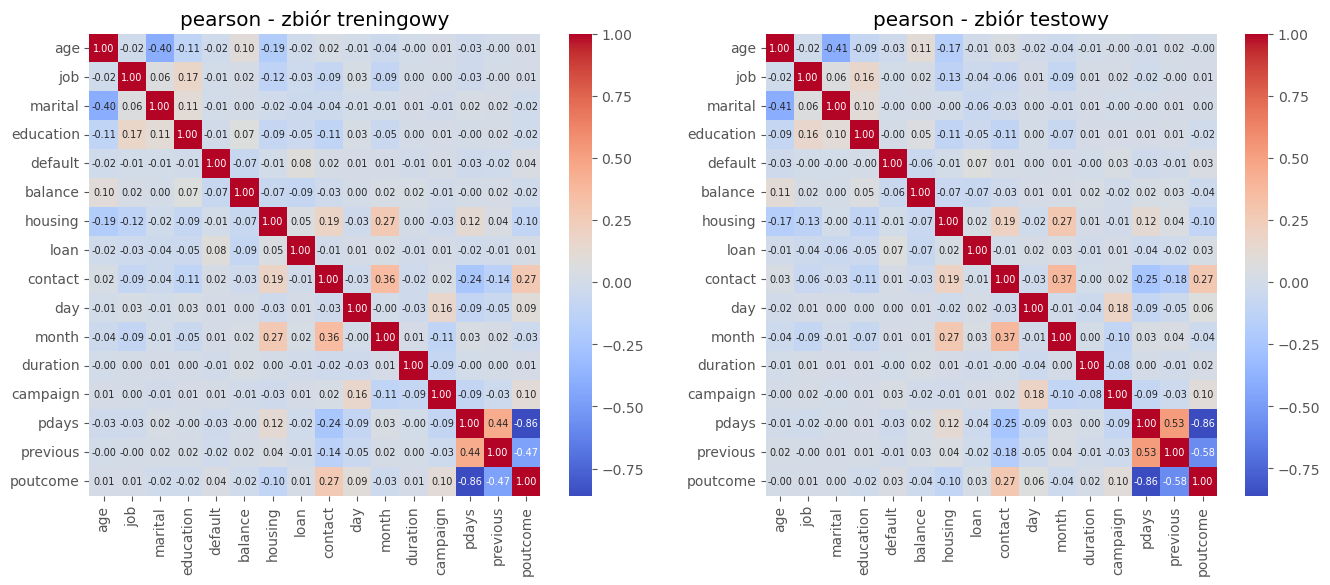

In [97]:
def plot_corr(method):
    
    correlation_train = X_train.corr(method=method)
    correlation_test = X_test.corr(method=method)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.heatmap(correlation_train, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0], annot_kws={"size": 7})
    axes[0].set_title(f"{method} - zbiór treningowy")
    
    sns.heatmap(correlation_test, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1], annot_kws={"size": 7})
    axes[1].set_title(f"{method} - zbiór testowy")
    
    plt.show()

plot_corr("pearson")

Widzimy, iż przedstawione macierze korelacji Pearsona dla obu zbiorów są bardzo do siebie zbliżone, co sugeruje poprawność podziału danych. Jedyne większe różnice zauważalne są w korelacjach między pdays i previous (0.44 i 0.53) oraz previous i poutcome (-0.47 i -0.58). Analizując obie macierze, widzimy, iż bardzo silna negatywna korelacja występuje między cechami **pdays i poutcome** (liczba dni od ostatniego kontaktu klienta w poprzedniej kampanii i wynik poprzedniej kampanii marketingowej). Wysoka ujemna korelacja występuje też między zmiennymi **previous i puotcome** (liczba kontaktów wykonanych przed tą kampanią dla danego klienta i wynik poprzedniej kampanii marketingowej). Z kolei dość wysoka pozytywna korelacja występuje między **previous i pdays** (liczba kontaktów wykonanych przed tą kampanią dla danego klienta i liczba dni od ostatniego kontaktu klienta w poprzedniej kampanii), co może oznaczać, że klienci, którzy byli kontaktowani wiele razy w przeszłości, nie są kontaktowani bardzo często - mijają dłuższe okresy między kontaktami. Jednak kiedy obliczamy korelacje dla zmiennych kategorycznych, rezultaty mogą nie wynikać z rzeczywistej zależności, dlatego trudno identyfikować niektóre z otrzymanych wartości.

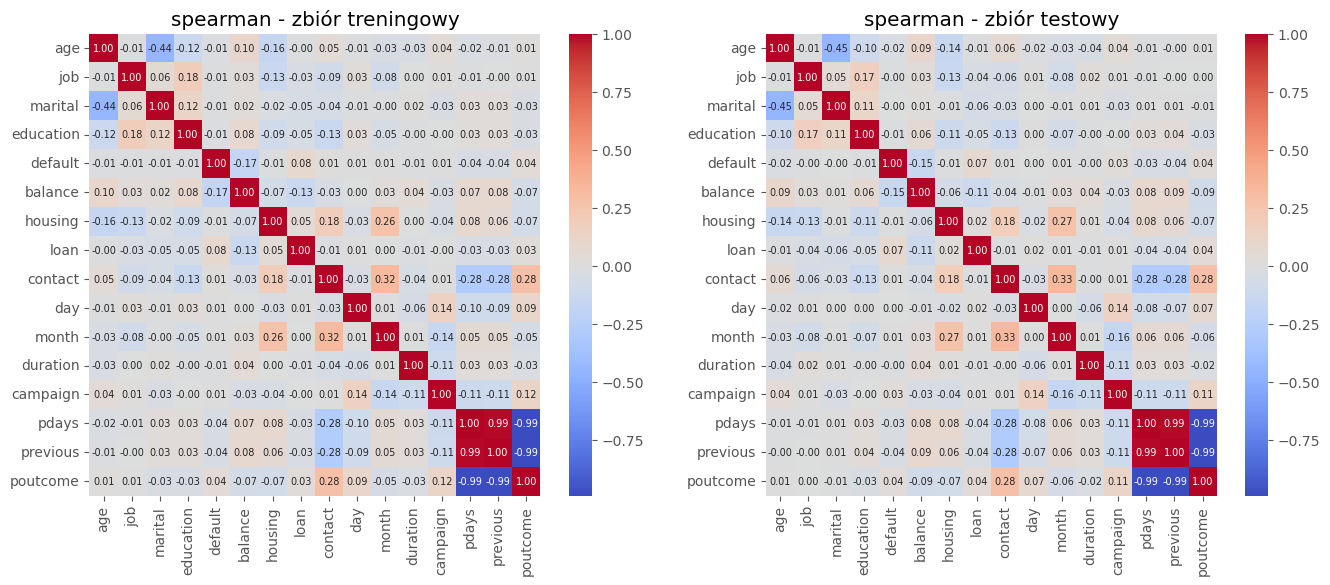

In [99]:
plot_corr("spearman")

Możemy zauważyć, że w sytuacji korelacji Spermana uzyskane macierze dla zbiorów treningowego i testowego są jeszcze bardziej zbliżone do siebie niż w sytuacji korelacji Pearsona. Widzimy, iż, tak jak poprzednio, bardzo wysoka negatywna korelacja występuje między zmiennymi **pdays i poutcome** oraz **previous i poutcome**, lecz jest ona jeszcze niższa i wynosi aż -0.99. Natiomiast bardzo wysoka pozytywna korelacja występuje ponownie między cechami **previous i pdays**, jednak jest ona jeższe wyższa i osiąga wartość 0.99.

#### SPRAWDZENIE WYSTĘPOWANIA DUPLIKATÓW

W tej części raportu zostanie sprawdzone, czy w danych występują duplikaty. Jest to kluczowy krok w procesie czyszczenia danych, gdyż powielone obserwacje mogą prowadzić do błędnych wniosków oraz zaburzenia działania modeli predykcyjnych. Wyliczę zatem liczbę duplikatów występujących w zbiorach treningowym i testowym.

In [102]:
X_train.duplicated().sum()

0

In [103]:
X_test.duplicated().sum()

0

Widzimy, iż w obu przypadkach dostaliśmy liczbę **0**. Tak musi być, ponieważ każda obserwacja reprezentuje unikalną osobę. Dane pochodzą z kampanii marketingowej banku, gdzie każdy wiersz zawiera informacje o indywidualnym kliencie.

#### SPRAWDZENIE WYSTĘPOWANIA PUSTYCH WARTOŚCI

W tej części zostanie sprawdzone, czy w rozważanych danych występują puste wartości, czyli braki danych. Mogą one pojawić się w danych z różnych powodów, takich jak błędy w procesie zbierania danych, niekompletne informacje od klientów czy też problemy techniczne podczas ich przetwarzania. Ich występowanie może zaburzać analizę i wpływać na jakość predykcji. Sprawdzę zatem, czy puste wartości występują w analizowanych zbiorach treningowym i testowym.

In [107]:
missing_train = X_train.isna().sum()
missing_test = X_test.isna().sum()

missing_report = pd.DataFrame({
    'Braki w zbiorze treningowym': missing_train,
    'Braki w zbiorze testowym': missing_test
})
missing_report

,Braki w zbiorze treningowym,Braki w zbiorze testowym
age,0,0
job,0,0
marital,0,0
education,0,0
default,0,0
balance,0,0
housing,0,0
loan,0,0
contact,0,0
day,0,0


Przeprowadzona analiza wykazała, że zarówno w zbiorze treningowym, jak i testowym nie występują żadne puste wartości. Oznacza to, że dane są kompletne i nie wymagają dodatkowego uzupełniania ani usuwania rekordów.

#### SPRAWDZENIE WYSTĘPOWANIA OBSERWACJI ODSTAJĄCYCH

Występowanie obserwacji odstających zostało wykonane pośrednio we wcześniejszej części, gdzie sprawdzane były rozkłady wszystkich zmiennych. Jednak teraz w tym celu zostanie wykorzystana **metoda Tukey fence**. Opiera się ona na rozstępie międzykwartylowym, który określa zakres wartości znajdujących się pomiędzy pierwszym i trzecim kwartylem. Wartości odstające definiuje się jako te, które nie należą do przedziału $(Q_1 - k \cdot IQR, Q_3 + k \cdot IQR)$. Obserwacje znajdujące się poza tym zakresem uznawane są za potencjalne wartości odstające. W naszym przypadku przyjmujemy $k = 3$, aby uzyskać wartości skrajnie odstające. Utworzę zatem funkcję, która realizuję tę metodę, a następnie przedstawię uzyskane wyniki w tabeli.

In [110]:
def tukey_var(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    outliers = df[(df[column] <= lower_bound) | (df[column] >= upper_bound)]
    
    return [column, df[column].nunique(), len(outliers), (len(outliers) / len(df)) * 100]

tukey_analysis = pd.DataFrame(columns=['Variable', 'Unique Values', 'Number of outliers', 'Percentage of outliers'])

for ft in dane.select_dtypes(include=['number']).columns:
    tukey_analysis.loc[len(tukey_analysis)] = tukey_var(dane, ft)

tukey_analysis

,Variable,Unique Values,Number of outliers,Percentage of outliers
0,customer_id,45211,0,0.000000
1,age,77,5,0.011059
2,balance,7168,2444,5.405764
3,day,31,0,0.000000
4,duration,1573,1158,2.561324
5,campaign,48,1789,3.957002
6,pdays,559,45211,100.000000
7,previous,41,45211,100.000000


Przeprowadzona analiza  pozwala wyciągnąć następujące wnioski:

* w rozkładzie zmiennej **age** występuje zaledwie 5 obserwacji skrajnie odstających; w tym przypadku za obserwacje te uznaje się klientów banku w wieku co najmniej 93 lat ,
* w rozkładzie zmiennej **balance** występuje aż 2444 obserwacji skrajnie odstających, co stanowi około 5% wszystkich obserwacji; jak wiemy z wcześniejszej części raportu, wśród klientów banku występują zarówno osoby o bardzo wysokim saldzie, jak i takie, których saldo jest ujemne,
* w rozkładzie zmiennej **day** nie występują obserwacje odstające, co jest zgodne z intuicją, gdyż nie istnieją ekstremalne wartości w kontekście dni miesiąca,
* w rozkładzie zmiennej **duration** występuje 1158 obserwacji skrajnie odstających, co stanowi około 3% wszystkich obserwacji; wiemy, iż niektóre rozmowy z klientami trwały znacznie dłużej niż typowe, a za obserwacje odstające przyjęto w tym przypadku te, które trwały co najmniej 967 sekund, czyli ponad 16 minut,
* w rozkładzie zmiennej **campaign** występuje 1789 obserwacji skrajnie odstających, co stanowi około 4% wszystkich obserwacji; niektóre osoby były kontaktowane znacznie częściej niż większość klientów, a za obserwacje odstające przyjęto te, dla których liczba kontaktów wynosiła co najmniej 9,
* w rozkładzie zmiennej **pdays** za obserwacje skrajnie odstające uznaje się wszystkie obserwacje, gdyż zarówno dolna, jak i górna granica wynoszą -1; może to być spowodowane tym, że większość klientów nie była wcześniej kontaktowana (zmienna przyjmuje wówczas wartość -1),
* w rozkładzie zmiennej **previous** także za obserwacje skrajnie odstające uznaje się wszystkie obserwacje, gdyż zarówno dolna, jak i górna granica wynoszą 0; może to być spowodowane tym, że liczba kontaktów wykonanych przed bieżącą kampanią dla większości klientów wynosi 0.

#### SPRAWDZENIE ZALEŻNOŚCI ZE ZMIENNĄ OBJAŚNIANĄ

W tej części raportu zostaną przeanalizowane zależności pomiędzy zmiennymi objaśniającymi a zmienną objaśnianą (y). Celem tej analizy jest zrozumienie, w jaki sosób poszczególne zmienne wpływają na zmienną docelową i jak te zależności mogą pomóc w modelowaniu oraz przewidywaniu zmiennej objaśnianej. Napiszę zatem dwie funkcje, które:

* dla **zmiennych kategorycznych** obliczają liczbę wystąpień w poszczególnych kategoriach i średni poziom zmiennej objaśnianej w każdej kategorii,
* dla **zmiennych ciągłych** dzielą dane na przedziały, aby stworzyć zmienne dyskretne, a następnie dla każdego przedziału obliczają liczbę wystąpień i średnią wartość zmiennej objaśnianej; aby podzielić na przedziały, najczęściej użyję metody qcut, która dzieli na przedziały mniej więcej o równej liczbie obserwacji, co jest ważne, gdy dane są silnie zróżnicowane.

Dzięki tym metodom można łatwo zauważyć, czy istnieją wyraźne zależności pomiędzy poszczególnymi zmiennymi a zmienną objaśnianą, co stanowi istotny krok w analizie danych. Przedstawię teraz dla każdej cechy wykres ukazujący omawianą zależność. Zrobię to tylko dla danych ze zbioru treningowego, gdyż wiemy już, że omawiane dane mają bardzo podobną strukturę.

In [118]:
def plot_comparison_discrete(col):
    
    df_grouped = dane2.iloc[X_train.index, :].groupby(col, as_index=False).agg(
        COUNT=(col, "count"),
        sr_y=("y", "mean")
    )


    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.bar(df_grouped[col], df_grouped["COUNT"], color='purple', alpha=0.7, label="liczba wystąpień")
    ax1.set_xlabel(col)
    ax1.set_ylabel("liczba wystąpień", color='purple')
    ax1.tick_params(axis='y', labelcolor='purple')

    unique_labels = sorted(df_grouped[col].unique())
    ax1.set_xticks(range(len(unique_labels)))
    ax1.set_xticklabels([encoder_dict[col][label] for label in unique_labels], rotation=90)

    ax2 = ax1.twinx()
    ax2.scatter(df_grouped[col], df_grouped["sr_y"], color='black', marker='o', label="średni poziom sukcesu")
    ax2.set_ylabel("średni poziom sukcesu", color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    plt.title(f'Zależność {col} ze zmienną objaśnianią')
    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.show()



def plot_comparison_continuous(col, bins=5, method="qcut"):

    df = dane2.copy()
    if method == "qcut":
        df["binned"] = pd.qcut(df[col], q=bins, duplicates='drop')
    elif method == "cut":
        df["binned"] = pd.cut(df[col], bins=bins)

    df_grouped = df.iloc[X_train.index, :].groupby("binned", as_index=False).agg(
        COUNT=(col, "count"),
        sr_y=("y", "mean")
    )

    fig, ax1 = plt.subplots(figsize=(12, 6))

    bars = ax1.bar(df_grouped["binned"].astype(str), df_grouped["COUNT"], 
                   color='purple', alpha=0.7, label="liczba wystąpień")
    ax1.set_xlabel(col)
    ax1.set_ylabel("liczba wystąpień", color='purple')
    ax1.tick_params(axis='y', labelcolor='purple')

    labels = [f"[{round(interval.left,1)}, {round(interval.right,1)}]" for interval in df_grouped["binned"]]
    ax1.set_xticks(range(len(df_grouped)))  
    ax1.set_xticklabels(labels, rotation=90)  

    ax2 = ax1.twinx()
    ax2.scatter(range(len(df_grouped)), df_grouped["sr_y"], 
                color='black', marker='o', label="średni poziom sukcesu")
    ax2.set_ylabel("średni poziom sukcesu", color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    plt.title(f'Zależność {col} ze zmienną objaśnianą')
    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()

##### AGE - WIEK KLIENTA BANKU

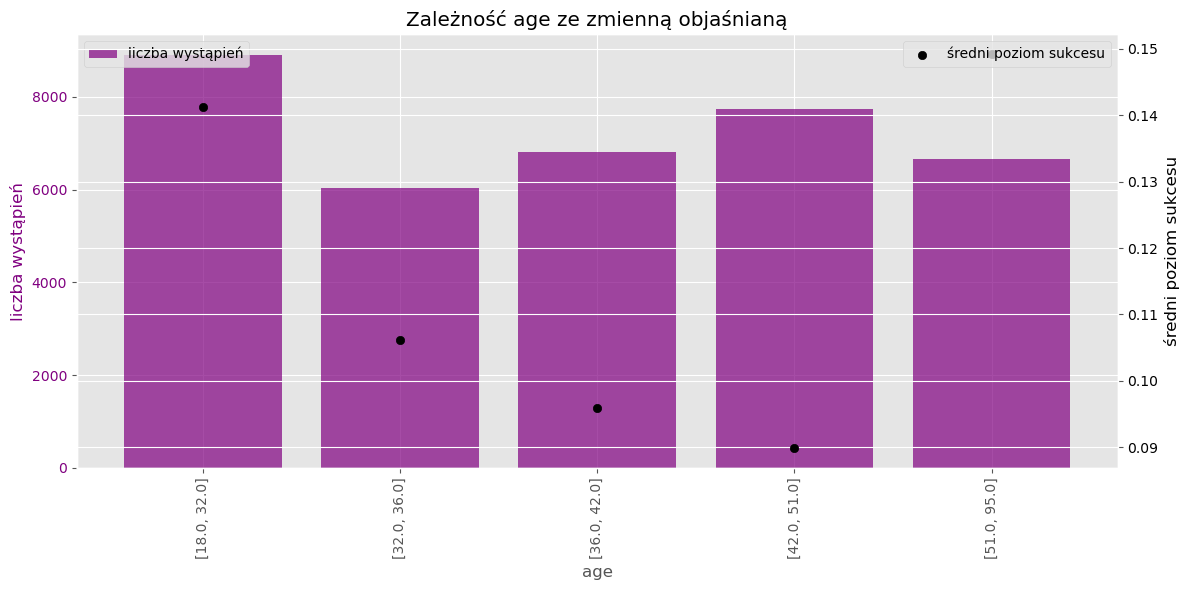

In [121]:
plot_comparison_continuous("age")

Widzimy, iż metoda qcut działa w taki sposób, że liczba klientów banku w każdej grupie jest zbliżona, ale szerokość przedziałów wiekowych się różni. Możemy zauważyć, iż najniższy średni poziom sukcesu ma grupa 42-51 lat, a najwyższy - 51-95 lat. Może to sugerować, że najstarsi klienci banku są bardziej skłonni do podejmowania decyzji finansowych. Wysoki średni poziom sukcesu występuje też w najmłodszej grupie wiekowej (18-32 lata), a następnie poziom ten maleje, aż do grupy najstarszej, gdzie jest najwyższy.

##### JOB - RODZAJ PRACY KLIENTA BANKU

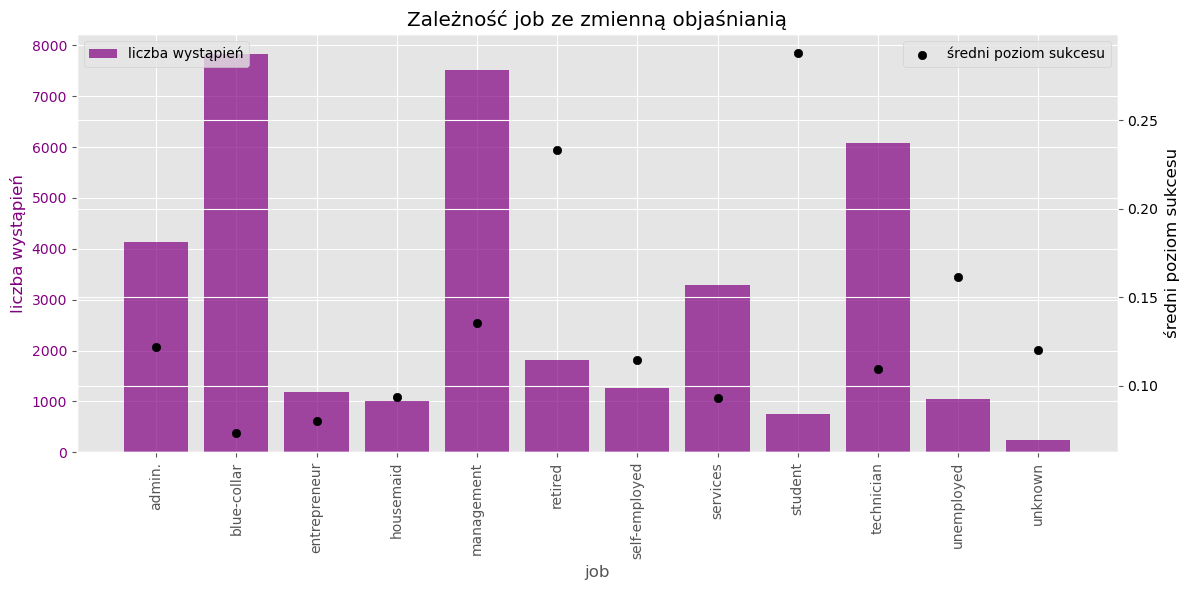

In [125]:
plot_comparison_discrete("job")

Widzimy, iż najwyższy średni poziom sukcesu występuje w grupie student (studenci), co może (mimo iż grupa ta nie jest zbyt liczna) świadczyć o ich otwartości na nowe oferty. Wysoki średni poziom sukcesu występuje również w grupach retired (emeryci) i unemployed (bezrobotni). Z kolei najniższy średni poziom sukcesu występuje w grupie blue-collar (robotnicy fizyczni). Niskie wartości można też zaobserwować w grupach enterpreneur (przedsiębiorcy) i housemaid (pomoc domowa).

##### MARITAL - STAN CYWILNY KLIENTA BANKU

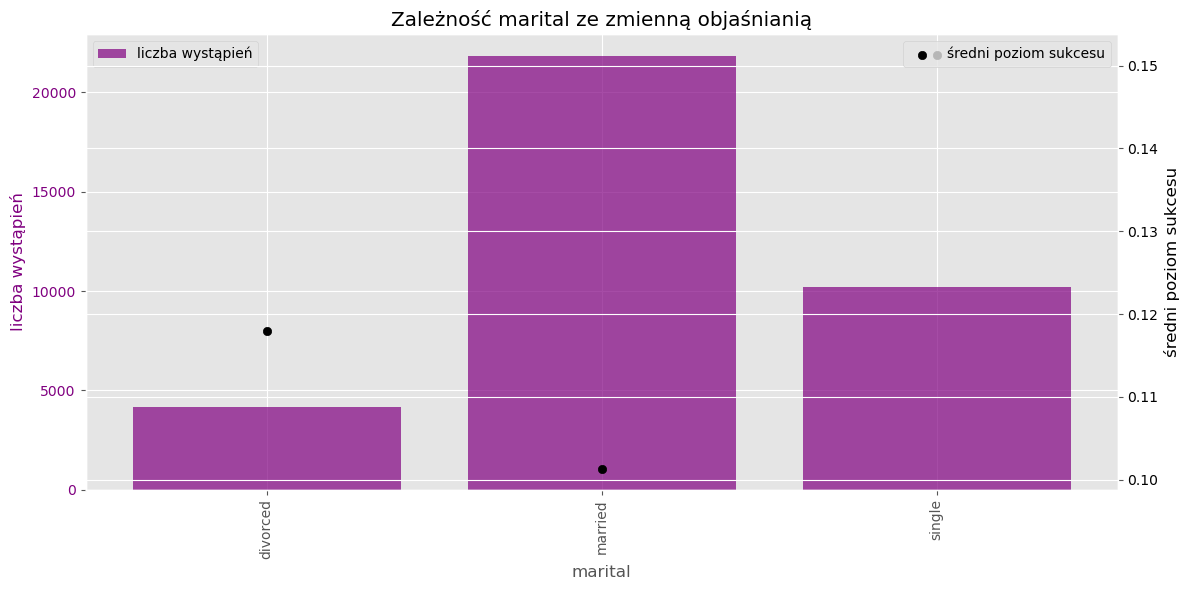

In [129]:
plot_comparison_discrete("marital")

Na przedstawionym wykresie możemy zauważyć, iż najwyższy średni poziom sukcesu występuje w grupie single (osoby samotne), co może sugerować ich większość otwartość na ofertę i większą samodzielność. Z kolei najniższy średni poziom sukcesu można zaobserwować w grupie married (osoby żonate/zamężne), mimo iż grupa ta jest zdecydowanie najliczniejsza. Natomiast grupa divorced (osoby rozwiedzione) mają pośredni poziom sukcesu.

##### EDUCATION - POZIOM WYKSZTAŁCENIA KLIENTA BANKU

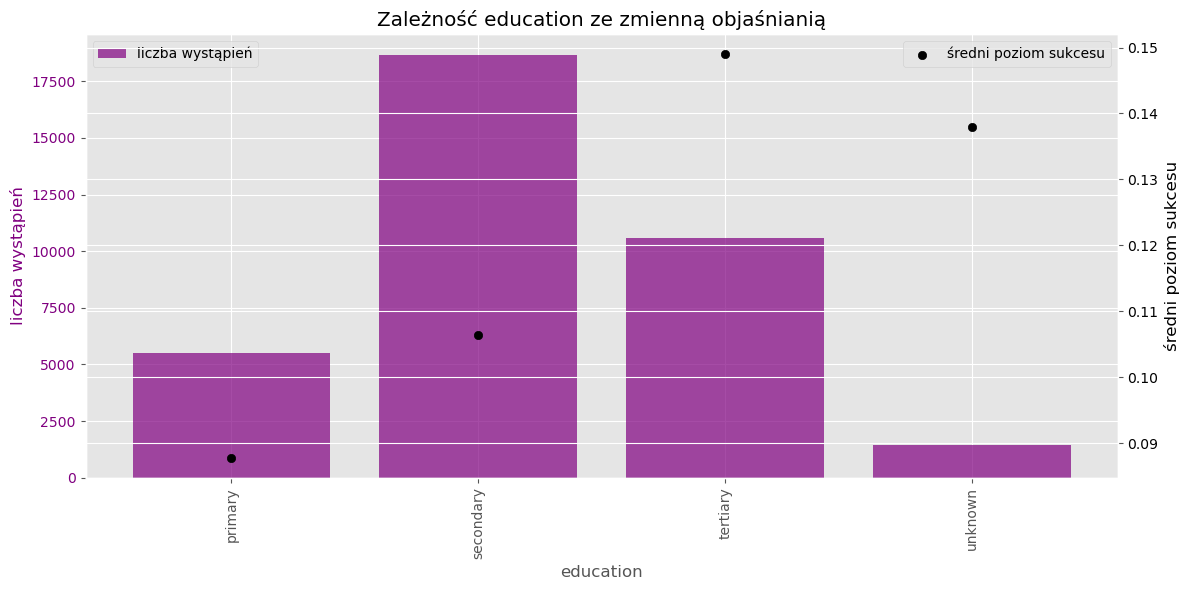

In [133]:
plot_comparison_discrete("education")

Widzimy, iż najwyższy średni poziom sukcesu występuje w grupie tertiary (wykształcenie wyższe), co może wskazywać na to, iż osoby lepiej wykształcone są bardziej świadome potencjalnych korzyści i bardziej otwarte na propozycje. Dalej, niższy średni poziom sukcesu można zaobserwować w grupie secondary (wykształcenie średnie), a najniższy - w grupie primary (wykształcenie podstawowe). Można zatem przypuszczać, że im niższy poziom wykształcenia klienta banku, tym mniejsza szansa na odniesienie sukcesu. Widzimy ponadto, że wysoki poziom sukcesu występuje też w grupie unknown.

##### DEFAULT - CZY KLIENT BANKU MA ZALEGŁOŚCI W SPŁACIE KREDYTU?

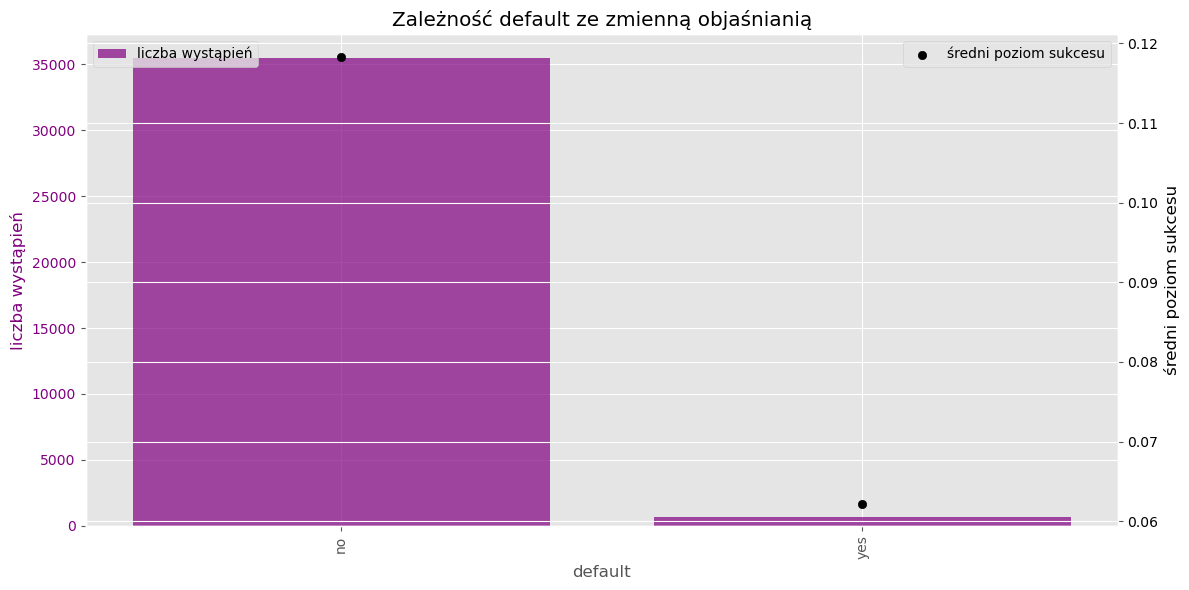

In [137]:
plot_comparison_discrete("default")

Możemy zauważyć, iż w grupie klientów bez zaległości w spłacie kredytu (no) średni poziom sukcesu jest znacznie wyższy. Z kolei w drugiej grupie, w której klienci banku mają zaległości (yes), średni poziom sukcesu jest bardzo niski. Warto jednak podkreślić, iż grupa ta jest mało liczna. Można zatem przypuszczać, że osoby terminowo spłacające swoje zobowiązania są bardziej skłonne do skorzystania z oferty.

##### BALANCE - ŚREDNIE ROCZNE SALDO NA KONCIE KLIENTA BANKU (W EURO)

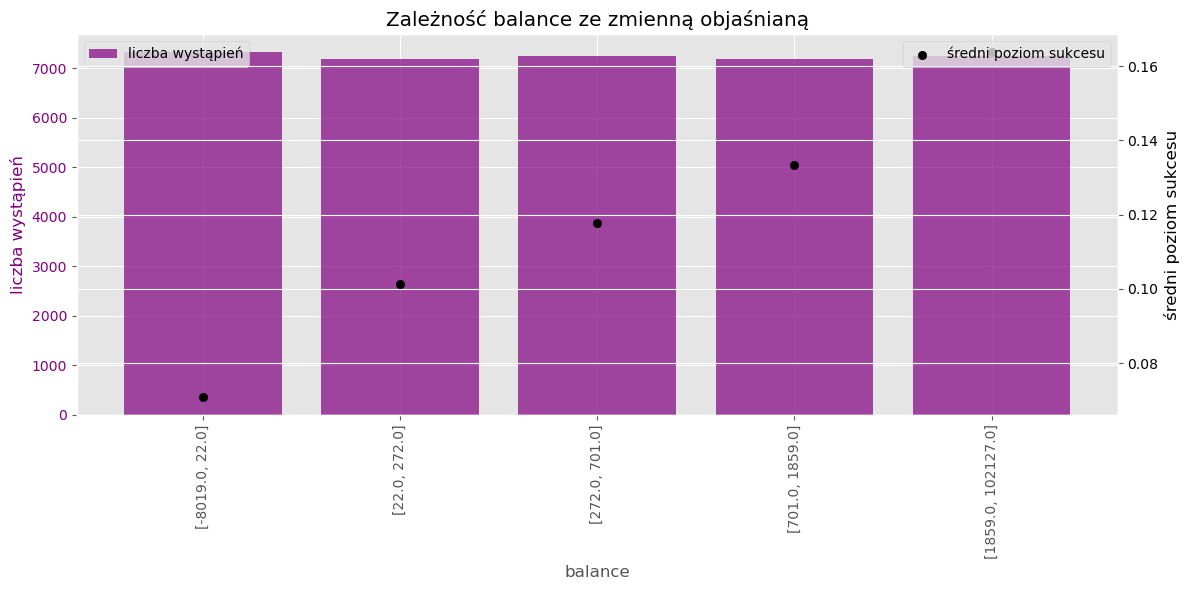

In [141]:
plot_comparison_continuous("balance")

Na przedstawionym wykresie wyraźnie widzimy, iż im wyższe saldo konta klienta banku, tym większa jego skłonność do skorzystania z oferty. Może to sugerować, iż osoby z większymi oszczędnościami mogą czuć się stabilne finansowo i otwarte na nowe produkty. Widzimy, iż najniższy średni poziom sukcesu mają przeważnie osoby z ujemnym saldem na koncie, z kolei najwyższy - klienci z bardzo dużym saldem.

##### HOUSING - CZY KLIENT BANKU MA KREDYT HIPOTECZNY?

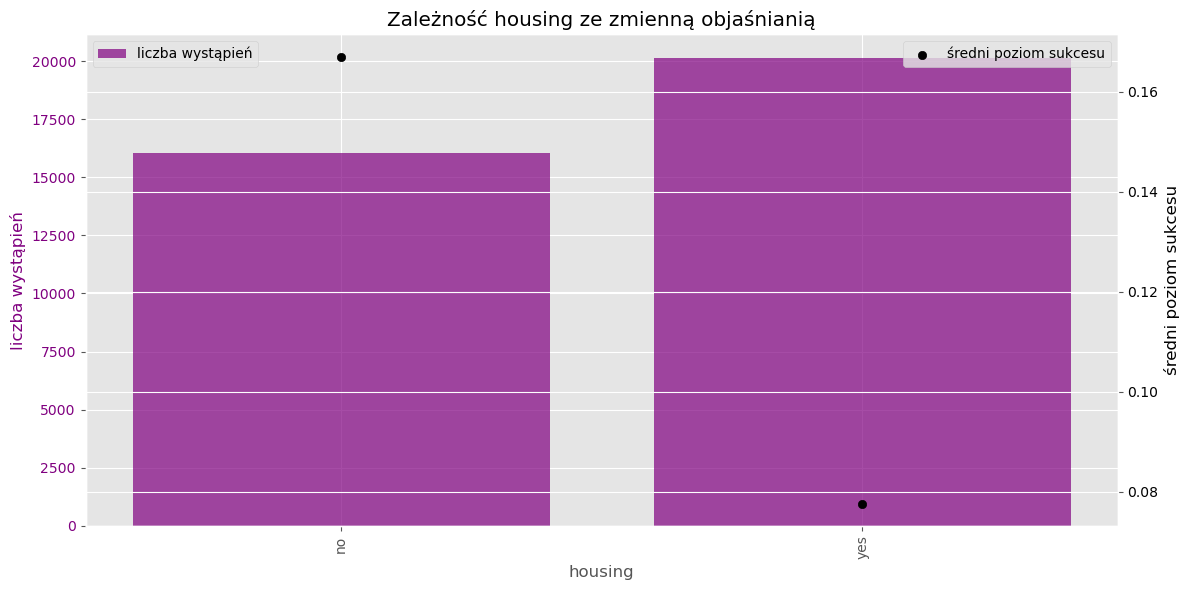

In [145]:
plot_comparison_discrete("housing")

Możemy zauważyć, iż osoby bez kredytu hipotecznego (grupa no) mają znacznie wyższy średni poziom sukcesu niż osoby posiadające owy kredyt (grupa yes). Może to wskazywać na fakt, iż osoby bez kredytu hipotecznego mają większą swobodę finansową lub są bardziej skłonne do podejmowania dodatkowych zobowiązań, z czego wynika ich większa chęć na korzystanie z oferty.

##### LOAN - CZY KLIENT MA KREDYT GOTÓWKOWY?

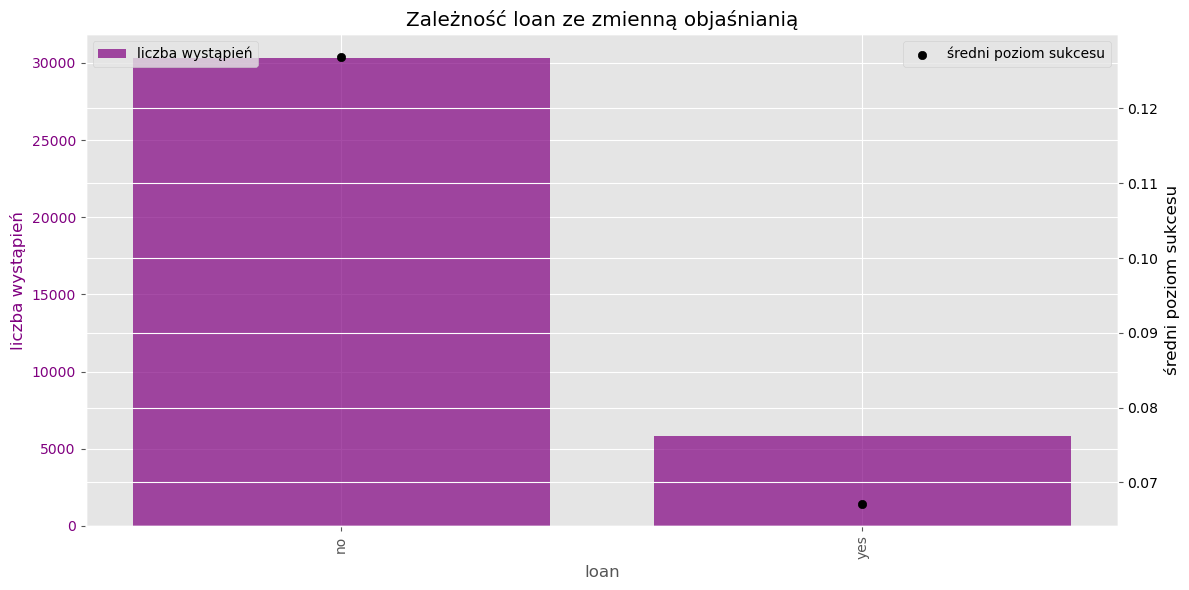

In [149]:
plot_comparison_discrete("loan")

Podobnie jak we wcześniejszym przypadku, osoby nieposiadające kredytu gotówkowego (grupa no) mają znacznie wyższy średni poziom sukcesu niż osoby, które owy kredyt mają (grupa yes). Może to wynikać z faktu, że osoby bez kredytu gotówkowego mają lepszą sytuację finansową i mniejsze obciążenia zobowiązaniami.

##### CONTACT - TYP KOMUNIKACJI

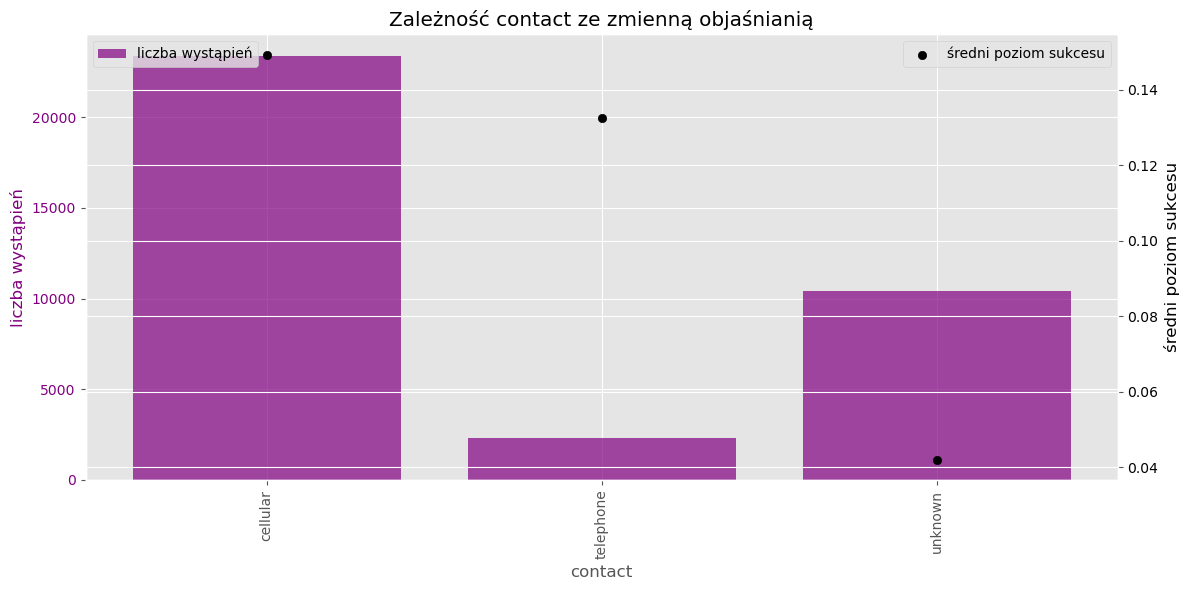

In [153]:
plot_comparison_discrete("contact")

Widzimy, iż w najliczniejszej grupie - cellular (telefon komórkowy) - średni poziom sukcesu jest najwyższy. Również wysoki, ale nieco niższy, poziom sukcesu można zaobserwować w grupie telephone (telefon stacjonarny), który jest znacznie rzadziej wykorzystywany. Widzimy także, że dla grupy unknown występuje najniższy średni poziom sukcesu. Zatem, możemy przypuszczać, że najlepsze wyniki osiąga kontakt przez telefon komórkowy.

##### DAY - DZIEŃ OSTATNIEGO KONTAKTU W MIESIĄCU

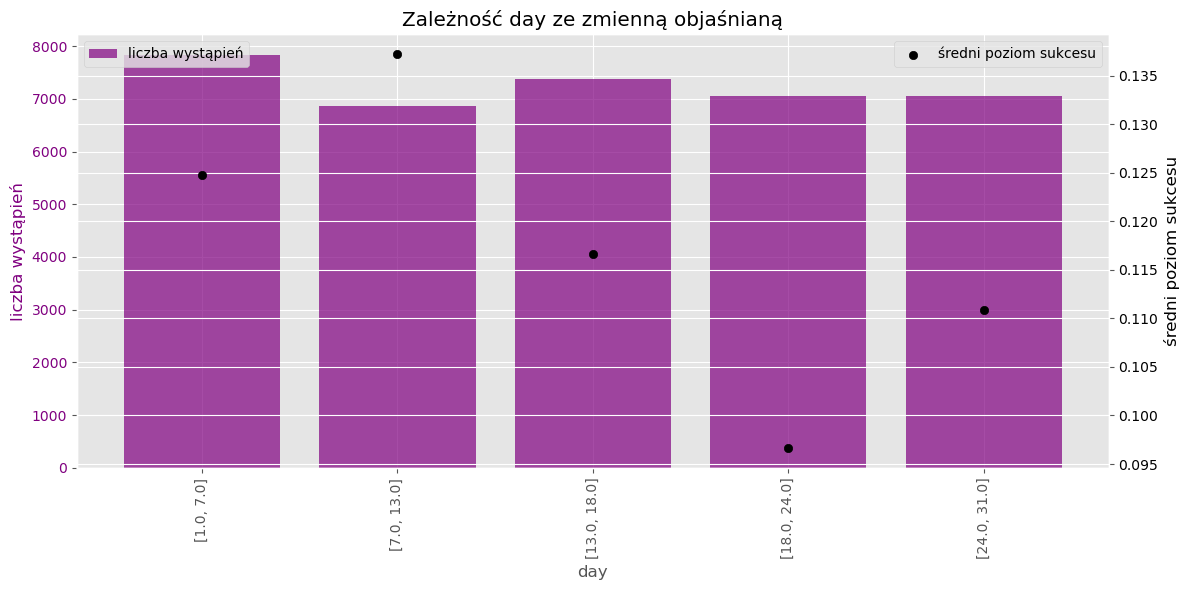

In [157]:
plot_comparison_continuous("day")

Widzimy, iż w tym przypadku uzyskane metodą qcut przedziały są mniej więcej równej długości, co sugeruje równomierny rozkład danych. Widzimy również, że najwyższy średni poziom sukcesu występuje w dniach 7-13, a następnie w dniach 1-7, co sugeruje, że w pierwszej połowie miesiąca obserwujemy największą szansę na sukces. Z kolei najniższy średni poziom sukcesu występuje w dniach 18-24, co może wskazywać, że w tym okresie klienci banku są mniej skłonni do podejmowania pozytywnej decyzji.

##### MONTH - MIESIĄC OSTATNIEGO KONTAKTU

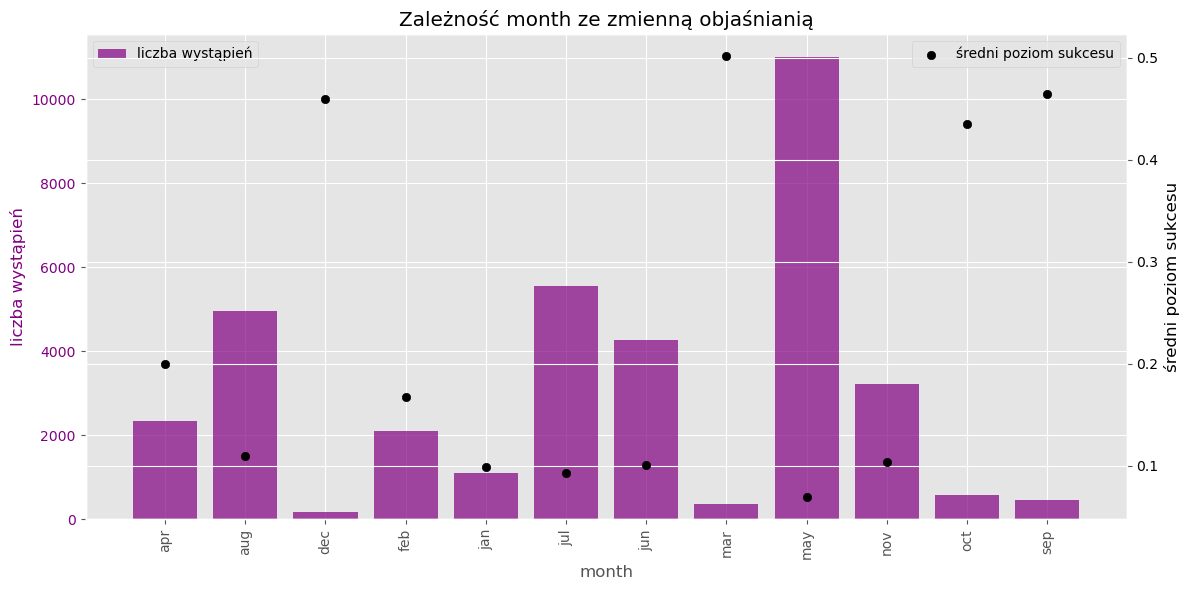

In [161]:
plot_comparison_discrete("month")

Widzimy, iż najniższy średni poziom sukcesu występuje w miesiącach maj, czerwiec, lipiec i sierpień. Warto zwrócić uwagę, że maj, mimo iż jest najliczniejszą grupą, ma najniższy poziom sukcesu. Z kolei najwyższy średni poziom sukcesu możemy zaobserwować w takich miesiącach, jak wrzesień, październik, grudzień i marzec, mimo ich niskiej liczebności. Może to sugerować, że są to najlepsze miesiące do kontaktu z klientami banku.

##### DURATION - CZAS TRWANIA OSTATNIEGO KONTAKTU (W SEKUNDACH)

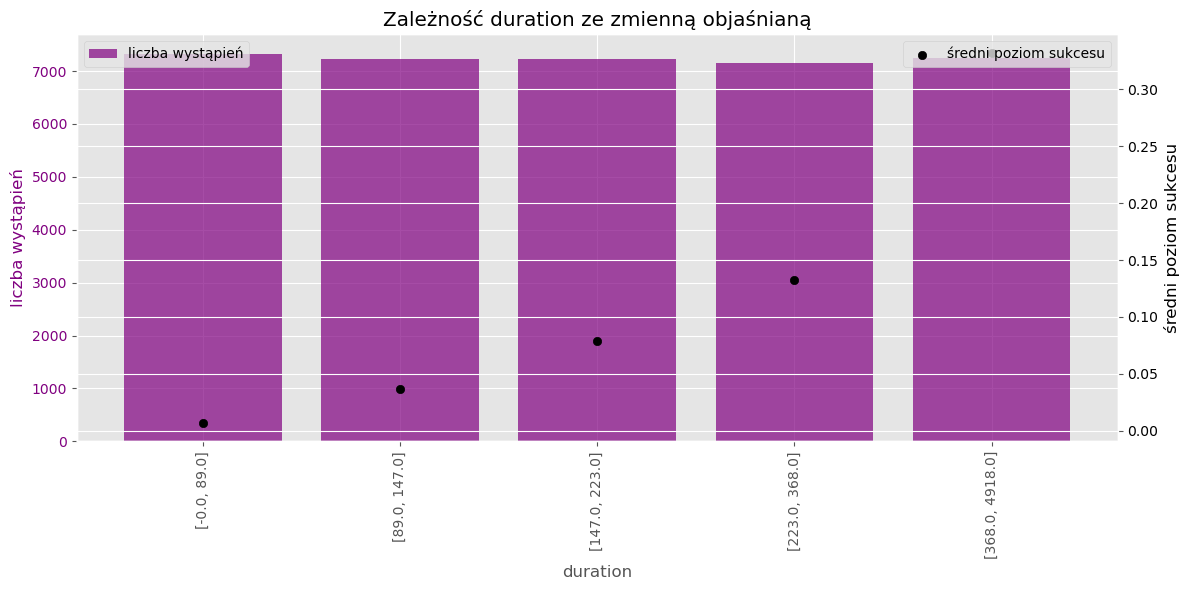

In [165]:
plot_comparison_continuous("duration")

Na przedstawionym wykresie wyraźnie widać, iż wraz ze wzrostem czasu trwania ostatniego kontaktu z klientem banku rośnie również średni poziom sukcesu. Najwyższy poziom sukcesu występuje w grupie najdłuższych rozmów, trawjących ponad 368 sekund, czyli ponad 6 minut. Z kolei najniższy średni poziom sukcesu występuje w grupie najkrótszych rozmów, nieprzekraczających 89 sekund, czyli około 1.5 minuty.

##### CAMPAIGN - LICZBA KONTAKTÓW WYKONANYCH W TEJ KAMPANII DLA DANEGO KLIENTA

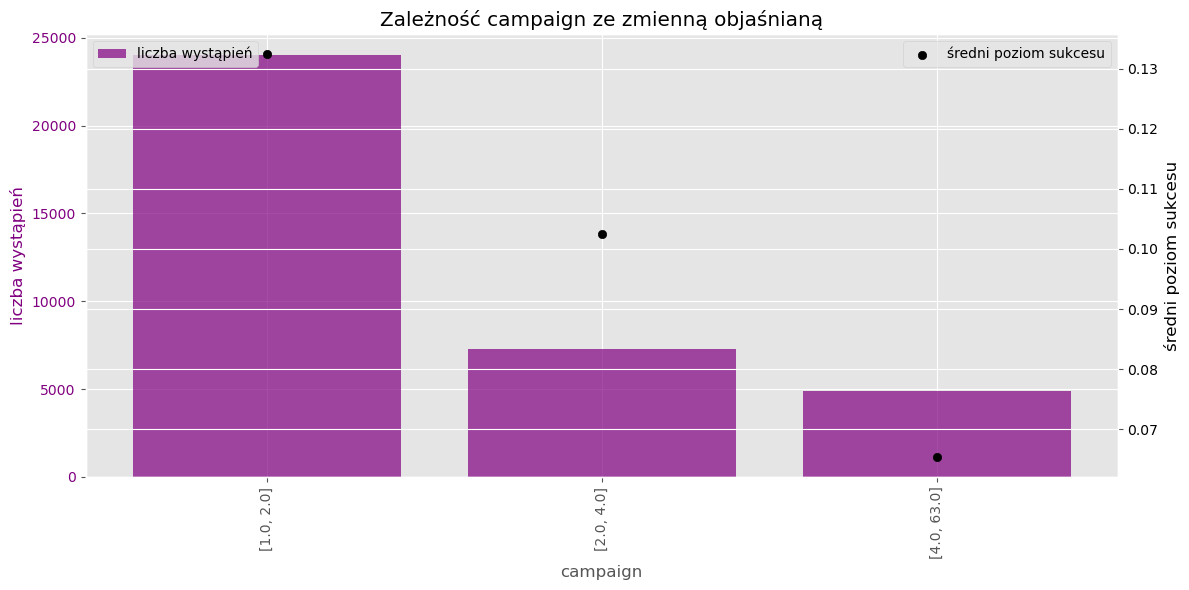

In [169]:
plot_comparison_continuous("campaign")

Wyraźnie widzimy, iż im większa liczba kontaktów wykonanych w tej kampanii dla danego klienta, tym mniejszy średni poziom sukcesu. Może to sugerować, że pierwsze podejścia są kluczowe - największa średnia skuteczność pojawia się przy 1-2 kontaktach. Z kolei wielokrotne kontakty obniżają skuteczność - im częściej występuje próba kontaktu, tym trudniej osiągnąć sukces. Najniższy średni poziom sukcesu wystąpił w grupie 4-63 kontaktów w tej kampanii.

##### PDAYS - LICZBA DNI OD OSTATNIEGO KONTAKTU KLIENTA W POPRZEDNIEJ KAMPANII

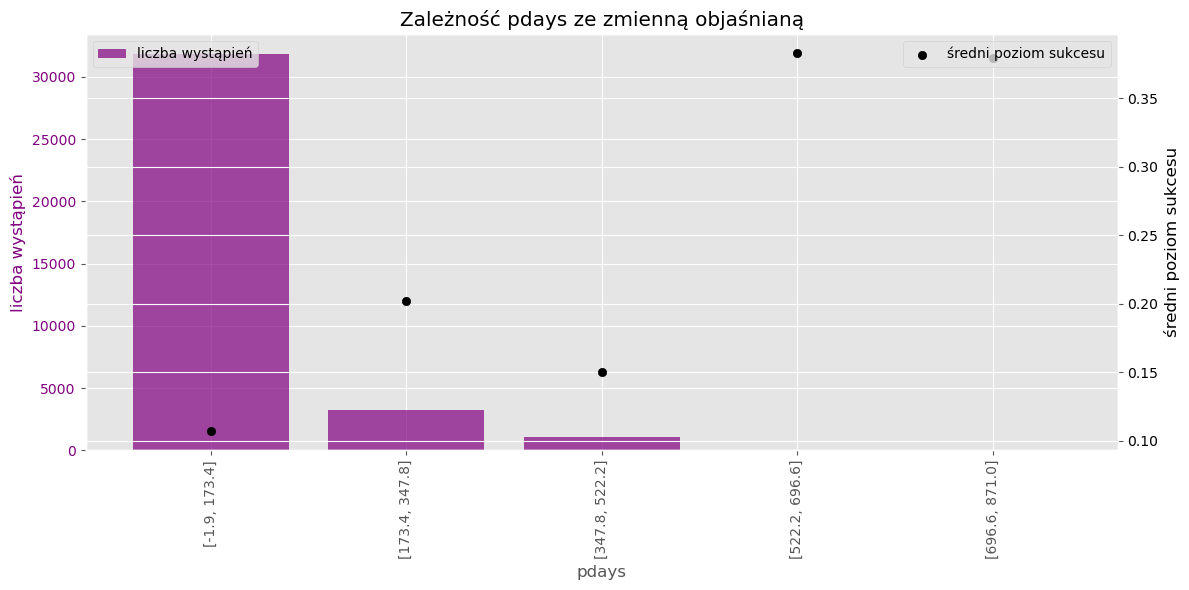

In [173]:
plot_comparison_continuous("pdays", method = "cut")

W tej sytuacji podział na przedziały został wykonany przy użyciu metody cut, gdyż w przeciwnym razie dostaliśmy tylko jeden przedział. Widzimy, iż w pierwszej grupie, mimo największej liczby obserwacji, występuje najniższy średni poziom sukcesu. Może to wskazywać na fakt, iż osoby, które nie były wcześniej kontaktowane lub były kontaktowane stosunkowo niedawno, najczęściej odmawiają. Widzimy również, że w grupach o bardzo dużej liczbie dni od ostatniego kontaktu klienta w poprzedniej kampanii średni poziom sukcesu jest najwyższy - klienci ci są najbardziej skłonni do pozytywnej decyzji.

##### PREVIOUS - LICZBA KONTAKTÓW WYKONANYCH PRZED TĄ KAMPANIĄ DLA DANEGO KLIENTA

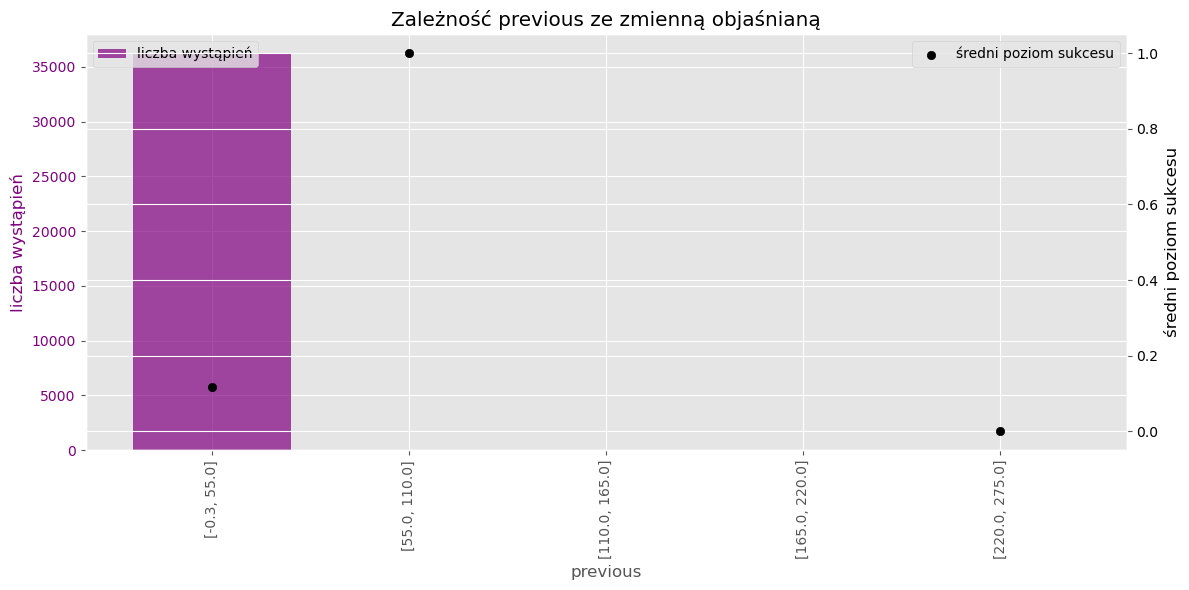

In [177]:
plot_comparison_continuous("previous", method = "cut")

W tej sytuacji, tak samo jak poprzednio, podział na przedziały został wykonany przy użyciu metody cut, gdyż w przeciwnym razie dostaliśmy tylko jeden przedział. Również w tej sytuacji pierwszy przedział jest bardzo szeroki i obejmuje prawie wszystkie przypadki - średni poziom sukcesu jest tam dość niski. Z kolei w przedziale 55-110 kontaktów występuje tylko dwóch klientów i każdy z nich przyjął złożoną ofertę. W dwóch następnych przedziałach nie ma żadnych obserwacji, z kolei w ostatnim przedziale jest ona tylko jedna (zakończona porażką). Na podstawie takiego wykresu trudno przeprowadzić dokładną analizę, gdyż dane rozłożone są bardzo nierównomiernie.

##### POUTCOME - WYNIK POPRZEDNIEJ KAMPANII MARKETINGOWEJ

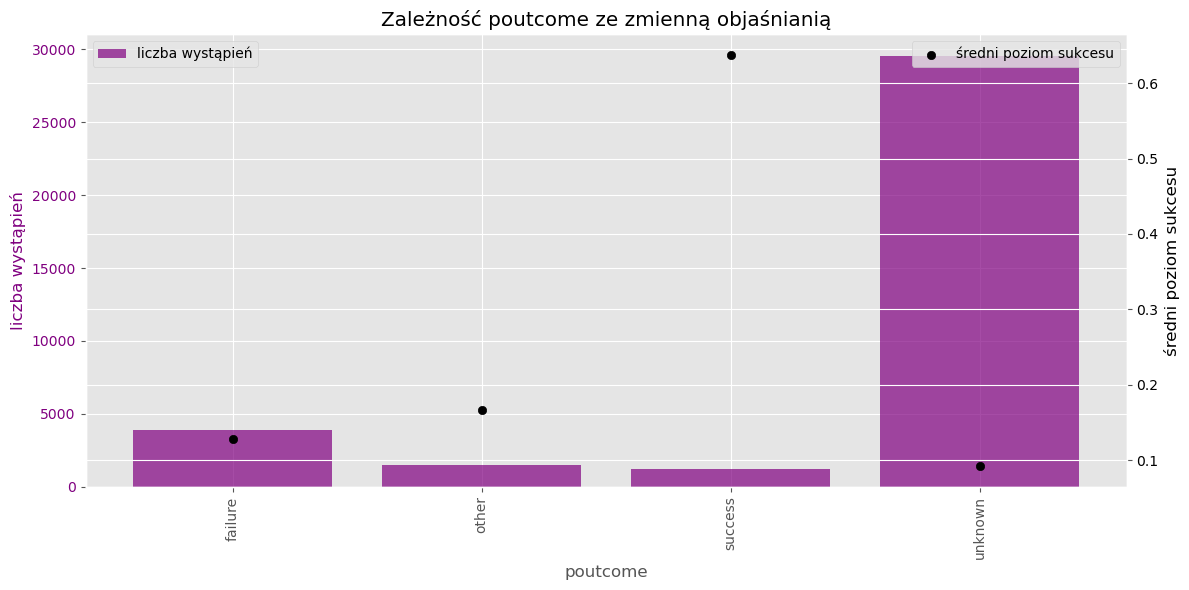

In [181]:
plot_comparison_discrete("poutcome")

Widzimy, iż u klientów, dla których wynik poprzedniej kampanii marketingowej to sukces (success) średni poziom sukcesu jest najwyższy. Pokazuje to, iż klienci banku, którzy zgodzili się w poprzedniej kampanii, są znacznie bardziej skłonni do ponownej zgody. Warto jednak zauważyć, iż grupa ta jest mało liczna. Z kolei najniższy średni poziom sukcesu występuje w grupie unknown. W grupie failure (niepowodzenia w poprzedniej kampanii) średni poziom sukcesu również nie jest wysoki - klienci, którzy wcześniej odmówili, nadal mają niską skłonność do zmiany decyzji. Widzimy też, że w grupie other występuje nieco wyższy poziom sukcesu niż w poprzedniej omawianej grupie.

#### WYJAŚNIENIE, CO UZNAJEMY ZA OBSERWACJĘ W PRÓBACH

W analizowanym zbiorze danych każda obserwacja reprezentuje **pojedynczego klienta**, a nie pojedynczy kontakt telefoniczny wykonany w ramach kampanii. Oznacza to, że wiersz danych zawiera pełne podsumowanie historii kontaktów z danym klientem, a nie zapis każdej próby kontaktu osobno.

Charakter danych wskazuje, że informacje są agregowane na poziomie klienta. Dowodem na to są zmienne takie jak pdays (liczba dni od ostatniego kontaktu). Te zmienne wskazują, że nie analizujemy pojedynczych interakcji, lecz całkowitą liczbę kontaktów przypisanych do danej osoby. W związku z tym w zbiorze danych nie występują duplikaty klientów – każdy klient pojawia się tylko raz, a jego historia kontaktu jest podsumowana w jednej obserwacji. Jest to kluczowe założenie dla analizy skuteczności kampanii, ponieważ sukces nie jest oceniany na podstawie pojedynczych telefonów, lecz całej strategii komunikacji z daną osobą.